## TODO

- Add Tau to table
- relative entropy per gene per tissue relative to isoform fractions in other tissues (KL divergence)?
- Should be doing the isoform ratios at the sample level before aggregating
- map GC grp to our isoform names

In [84]:
from itertools import combinations

import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tqdm

from data_loading import (
    load_tf_families, 
    load_gtex_remapped, 
    load_annotated_TFiso1_collection,
    load_valid_isoform_clones,
    load_ref_vs_alt_isoforms_table,
    load_m1h_activation_data,
)

In [2]:
df, metadata, genes = load_gtex_remapped()
tf_fam = load_tf_families()
tfs = load_annotated_TFiso1_collection()

reading from cache
reading from cache


In [3]:
# HSFY1 has something weird going on in the data loading
print(genes.loc[genes == 'HSFY1'])
print(tfs['HSFY1'].isoforms)

UID
HSFY1|1/2|12F03 nomatch    HSFY1
HSFY1|2/2|11F06 nomatch    HSFY1
dtype: object
[Clone acc: HSFY1|1/2|12F03
Isoform: HSFY1-1
length: 401 aa, Clone acc: HSFY1|2/2|11F06
Isoform: HSFY1-2
length: 214 aa]


In [4]:
# something weird with TEAD1-207|TEAD1-206 which have identical looking
# exon diagrams but different in our data
print(genes.loc[genes == 'TEAD1'])
print(tfs['TEAD1'].isoforms)

UID
TEAD1|5/5|11E10 TEAD1-201    TEAD1
noclone TEAD1-203            TEAD1
noclone TEAD1-205            TEAD1
noclone TEAD1-206            TEAD1
noclone TEAD1-207            TEAD1
dtype: object
[Clone acc: TEAD1|5/5|11E10
Isoform: TEAD1-201 / ENSP00000334754 / ENST00000334310
length: 357 aa, Isoform: TEAD1-203 / ENSP00000435393 / ENST00000526600
length: 330 aa, Isoform: TEAD1-205 / ENSP00000435977 / ENST00000527575
length: 368 aa, Isoform: TEAD1-206 / ENSP00000435233 / ENST00000527636
length: 426 aa, Isoform: TEAD1-207 / ENSP00000491500 / ENST00000638666
length: 426 aa]


In [5]:
means = df.groupby(df.columns.map(metadata['body_site']), axis=1).mean()
medians = df.groupby(df.columns.map(metadata['body_site']), axis=1).median()
tip_score = (means.sub(means.median(axis=1), axis=0)
                    .div(means.quantile(q=0.75, axis=1) -
                         means.quantile(q=0.25, axis=1), axis=0))
f_i = means.div(means.sum(axis=1), axis=0)
q_i = 1. / f_i.shape[1]  # this is relative entropy
entropy_per_isoform = (f_i.mul((f_i / q_i).apply(np.log2))).sum(axis=1)
# gene-level tissue-speceficity metrics
gene_means = df.groupby(genes).sum().groupby(df.columns.map(metadata['body_site']), axis=1).mean()
gene_medians = df.groupby(genes).sum().groupby(df.columns.map(metadata['body_site']), axis=1).mean()
gene_tip = (gene_means.sub(gene_means.median(axis=1), axis=0)
                    .div(gene_means.quantile(q=0.75, axis=1) -
                         gene_means.quantile(q=0.25, axis=1), axis=0))
f_i = gene_means.div(gene_means.sum(axis=1), axis=0)
q_i = 1. / f_i.shape[1]  # this is relative entropy
gene_entropy_per_isoform = (f_i.mul((f_i / q_i).apply(np.log2))).sum(axis=1)
iso = genes.to_frame(name='gene_symbol').copy()
iso['mean_logTPM'] = means.mean(axis=1)
iso['median_logTPM'] = medians.median(axis=1)
iso['max_logTPM'] = means.max(axis=1)
iso['max_TiP_score'] = tip_score.max(axis=1)
iso['tissue_with_max_TiP_score'] = tip_score.idxmax(axis=1)
iso['entropy'] = entropy_per_isoform
iso['gene_max_TiP_score'] = iso['gene_symbol'].map(gene_tip.max(axis=1))
iso['gene_entropy'] = iso['gene_symbol'].map(gene_entropy_per_isoform)
iso.head()

,gene_symbol,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy
UID,,,,,,,,,
AEBP2|2/3|05F03 nomatch,AEBP2,0.683160,0.513937,2.074463,2.031789,Bladder,0.323550,1.327742,0.087109
AEBP2|3/3|05E07 nomatch,AEBP2,0.193453,0.112085,0.559758,2.305831,Artery - Tibial,0.286039,1.327742,0.087109
ARNT2|1/6|08C12 ARNT2-201,ARNT2,2.694347,2.300076,6.134232,1.275719,Brain - Frontal Cortex (BA9),0.331286,2.177846,0.430500
ARNT2|2/6|09E01 nomatch,ARNT2,0.040305,0.000000,0.211308,3.990279,Brain - Frontal Cortex (BA9),0.946606,2.177846,0.430500
ARNT2|3/6|10D11 ARNT2-209,ARNT2,0.075643,0.000000,0.886964,56.593215,Brain - Hippocampus,2.231239,2.177846,0.430500


In [6]:
means.index.str.startswith('noclone').sum()

620

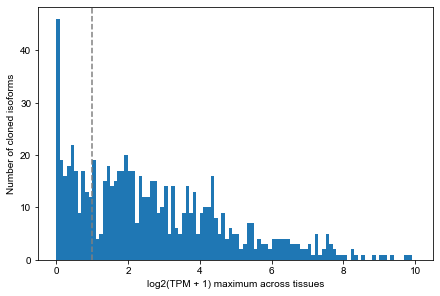

In [7]:
# plot fraction of mean TPM > 1 for cloned
means.loc[~means.index.str.startswith('noclone'), :].max(axis=1).plot.hist(bins=100, range=(0, 10))
plt.ylabel('Number of cloned isoforms')
plt.xlabel('log2(TPM + 1) maximum across tissues')
plt.axvline(x=1, color='grey', linestyle='--')
plt.savefig('../figures/tissue-expression_max-logTPM_per-cloned-isoform.pdf',
            bbox_inches='tight')

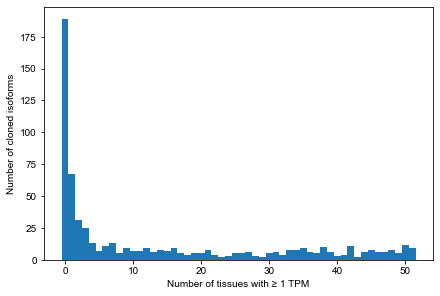

In [8]:
(means.loc[~means.index.str.startswith('noclone'), :] >= 1).sum(axis=1).plot.hist(bins=52, range=(-0.5, 51.5))
plt.ylabel('Number of cloned isoforms')
plt.xlabel('Number of tissues with ≥ 1 TPM')
plt.savefig('../figures/tissue-expression_n-tissues-gte-1TPM_per-cloned-isoform.pdf',
            bbox_inches='tight')

In [9]:
# try different measures of pairwise similarity of isoform expression
#- Range of expression ratios of two isoforms accross tissues (+ pseudo count)
#- Variance of expression ratios across tissues
#- Correlation between expression levels
#- Require a minimum number of tissues above the threshold (3 or 5)
pcc = means.T.corr(method='pearson')
scc = means.T.corr(method='spearman')
similarities = []
for gene in genes.unique():
    vals = means.loc[genes == gene, :].copy()
    vals.loc[:, vals.sum(axis=0) < 1] = np.nan
    vals.loc[(vals >= 1).sum(axis=1) == 0, :] = np.nan
    pcc_corrected = vals.T.corr()
    for iso_a, iso_b in combinations(genes.loc[genes == gene].index.values, 2):
        similarities.append([iso_a,
                             iso_b,
                             pcc.loc[iso_a, iso_b],
                             scc.loc[iso_a, iso_b],
                             pcc_corrected.loc[iso_a, iso_b]])
similarities = pd.DataFrame(data=similarities,
                            columns=['iso_a', 'iso_b', 'PCC', 'Spearmans', 'PCC_corrected'])
similarities.head()

,iso_a,iso_b,PCC,Spearmans,PCC_corrected
0,AEBP2|2/3|05F03 nomatch,AEBP2|3/3|05E07 nomatch,0.761984,0.827864,NaN
1,AEBP2|2/3|05F03 nomatch,noclone AEBP2-201,0.785630,0.809339,0.785630
2,AEBP2|2/3|05F03 nomatch,noclone AEBP2-202,0.769556,0.785554,0.769556
3,AEBP2|2/3|05F03 nomatch,noclone AEBP2-204,-0.239241,-0.283629,NaN
4,AEBP2|2/3|05F03 nomatch,noclone AEBP2-207,0.827873,0.866057,0.827873


In [10]:
cloned = (~similarities['iso_a'].str.startswith('noclone') & ~similarities['iso_b'].str.startswith('noclone'))
similarities.loc[cloned, :]

,iso_a,iso_b,PCC,Spearmans,PCC_corrected
0,AEBP2|2/3|05F03 nomatch,AEBP2|3/3|05E07 nomatch,0.761984,0.827864,NaN
15,ARNT2|1/6|08C12 ARNT2-201,ARNT2|2/6|09E01 nomatch,0.854209,0.858499,NaN
16,ARNT2|1/6|08C12 ARNT2-201,ARNT2|3/6|10D11 ARNT2-209,0.619284,0.321099,NaN
18,ARNT2|2/6|09E01 nomatch,ARNT2|3/6|10D11 ARNT2-209,0.582790,0.384444,NaN
21,ARNTL2|1/5|10H01 nomatch,ARNTL2|2/5|12C06 ARNTL2-204,0.930272,0.657760,NaN
...,...,...,...,...,...
3903,ZSCAN26|1/2|02H03 ZSCAN26-207,ZSCAN26|2/2|02D03 ZSCAN26-201_ZSCAN26-204,0.644032,0.625920,0.644032
3909,ZSCAN32|1/5|05B06 ZSCAN32-203,ZSCAN32|2/5|05F05 nomatch,0.579475,0.564932,NaN
3910,ZSCAN32|1/5|05B06 ZSCAN32-203,ZSCAN32|4/5|05H04 ZSCAN32-204,0.194229,0.434038,NaN
3916,ZSCAN32|2/5|05F05 nomatch,ZSCAN32|4/5|05H04 ZSCAN32-204,0.369084,0.483133,NaN


In [11]:
# compare to other pairwise similarity
pairs = load_ref_vs_alt_isoforms_table()

In [12]:
similarities

,iso_a,iso_b,PCC,Spearmans,PCC_corrected
0,AEBP2|2/3|05F03 nomatch,AEBP2|3/3|05E07 nomatch,0.761984,0.827864,NaN
1,AEBP2|2/3|05F03 nomatch,noclone AEBP2-201,0.785630,0.809339,0.785630
2,AEBP2|2/3|05F03 nomatch,noclone AEBP2-202,0.769556,0.785554,0.769556
3,AEBP2|2/3|05F03 nomatch,noclone AEBP2-204,-0.239241,-0.283629,NaN
4,AEBP2|2/3|05F03 nomatch,noclone AEBP2-207,0.827873,0.866057,0.827873
...,...,...,...,...,...
3938,ZSCAN9|1/3|11H08 ZSCAN9-201_ZSCAN9-207,noclone ZSCAN9-202,0.874849,0.896322,0.874849
3939,ZSCAN9|1/3|11H08 ZSCAN9-201_ZSCAN9-207,noclone ZSCAN9-208,0.677126,0.761311,NaN
3940,ZSCAN9|2/3|08H02 ZSCAN9-204,noclone ZSCAN9-202,0.875594,0.874443,0.875594
3941,ZSCAN9|2/3|08H02 ZSCAN9-204,noclone ZSCAN9-208,0.727002,0.797904,NaN


In [13]:
similarities.iloc[381:382, :]#.apply(get_pair_id, axis=1)

,iso_a,iso_b,PCC,Spearmans,PCC_corrected
381,noclone CREM-216,noclone CREM-226,0.659462,0.226948,NaN


In [14]:
pairs['pair'] = (pairs[['clone_acc_ref', 'clone_acc_alt']].min(axis=1)
                 + '_' +
                pairs[['clone_acc_ref', 'clone_acc_alt']].max(axis=1))

In [15]:
clones = load_valid_isoform_clones()

def get_pair_id(row):
    clone_accs_a = [x for x in row['iso_a'].split(' ')[0].split('_') if x in clones['clone_acc'].unique()]
    clone_accs_b = [x for x in row['iso_b'].split(' ')[0].split('_') if x in clones['clone_acc'].unique()]
    if len(clone_accs_a) == 0 or len(clone_accs_b) == 0:
        return np.nan
    return '_'.join(sorted([clone_accs_a[0], clone_accs_b[0]]))

similarities = similarities.loc[cloned, :]
similarities['pair'] = similarities.apply(get_pair_id, axis=1)
similarities = similarities.loc[similarities['pair'].notnull(), :]
if similarities['pair'].duplicated().any():
    raise UserWarning('unexpected duplicates')
if not pairs['pair'].isin(similarities['pair'].values).all():
    raise UserWarning('unexpected missing pairs')
pairs['tissue_expression_pcc'] = pairs['pair'].map(similarities.set_index('pair')['PCC_corrected'])

<ipython-input-15-16e24c2eacb2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similarities['pair'] = similarities.apply(get_pair_id, axis=1)


<ipython-input-16-3932a780b39d>:12: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Ensembl_gene_ID', 'Ensembl_transcript_IDs_alt',
       'Ensembl_transcript_IDs_ref', 'clone_acc_alt', 'clone_acc_ref',
       'dimer_ppi', 'family', 'gene_symbol', 'other_than_dimer_ppi', 'pair',
       'tf_cofactor_ppi', 'tf_signalling_ppi', 'tf_tf_ppi'],
      dtype='object')
  avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull(), :]


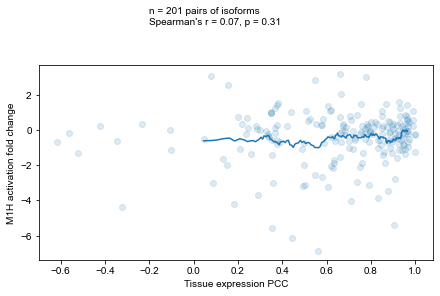

In [16]:
window_size = 30
var_x = 'tissue_expression_pcc'
var_y = 'activation_fold_change_log2'
xy = pairs.loc[pairs[var_x].notnull() &
               pairs[var_y].notnull(),
               [var_x, var_y]].values

fig, ax = plt.subplots(1, 1)
ax.scatter(xy[:, 0], xy[:, 1],
           clip_on=False, 
           alpha=0.15,)
avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull(), :]
        .sort_values(var_x)
        .rolling(window_size, center=True)
        .mean()[[var_x, var_y]]).dropna().values
ax.plot(avrg[:,0], avrg[:, 1])
ax.set_xlabel('Tissue expression PCC')
#ax.set_xlim(0, 100)
#ax.set_ylim(0, 1)
ax.set_ylabel('M1H activation fold change')
ax.text(s=('n = {} pairs of isoforms'.format(xy.shape[0]) + 
           "\nSpearman's r = {:.2f}, p = {:.2f}".format(*stats.spearmanr(xy[:, 0], xy[:, 1]))),
        x=-0.2, y=6.,
        ha='left')
fig.savefig('../figures/{}-vs-{}_scatter-with-moving-average.pdf'.format(var_x, var_y),
            bbox_inches='tight')

<ipython-input-17-75cb2310c736>:12: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Ensembl_gene_ID', 'Ensembl_transcript_IDs_alt',
       'Ensembl_transcript_IDs_ref', 'clone_acc_alt', 'clone_acc_ref',
       'dimer_ppi', 'family', 'gene_symbol', 'other_than_dimer_ppi', 'pair',
       'tf_cofactor_ppi', 'tf_signalling_ppi', 'tf_tf_ppi'],
      dtype='object')
  avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull(), :]


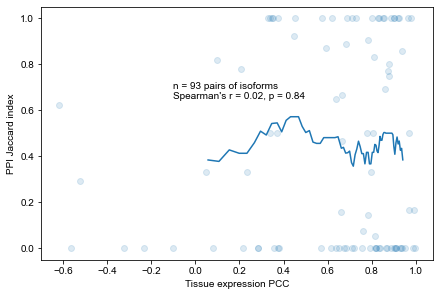

In [17]:
window_size = 20
var_x = 'tissue_expression_pcc'
var_y = 'PPI_jaccard'
xy = pairs.loc[pairs[var_x].notnull() &
               pairs[var_y].notnull(),
               [var_x, var_y]].values

fig, ax = plt.subplots(1, 1)
ax.scatter(xy[:, 0], xy[:, 1],
           clip_on=False, 
           alpha=0.15,)
avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull(), :]
        .sort_values(var_x)
        .rolling(window_size, center=True)
        .mean()[[var_x, var_y]]).dropna().values
ax.plot(avrg[:,0], avrg[:, 1])
ax.set_xlabel('Tissue expression PCC')
#ax.set_xlim(0, 100)
#ax.set_ylim(0, 1)
ax.set_ylabel('PPI Jaccard index')
ax.text(s=('n = {} pairs of isoforms'.format(xy.shape[0]) + 
           "\nSpearman's r = {:.2f}, p = {:.2f}".format(*stats.spearmanr(xy[:, 0], xy[:, 1]))),
        x=-0.1, y=0.65,
        ha='left')
fig.savefig('../figures/{}-vs-{}_scatter-with-moving-average.pdf'.format(var_x, var_y),
            bbox_inches='tight')

<ipython-input-18-9e5192c2c186>:12: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Ensembl_gene_ID', 'Ensembl_transcript_IDs_alt',
       'Ensembl_transcript_IDs_ref', 'clone_acc_alt', 'clone_acc_ref',
       'dimer_ppi', 'family', 'gene_symbol', 'other_than_dimer_ppi', 'pair',
       'tf_cofactor_ppi', 'tf_signalling_ppi', 'tf_tf_ppi'],
      dtype='object')
  avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull(), :]


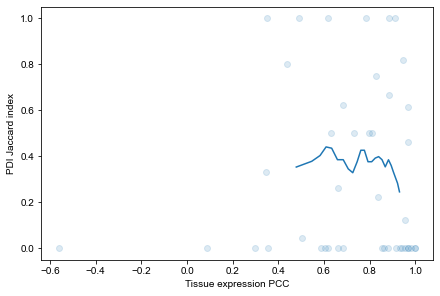

In [18]:
window_size = 20
var_x = 'tissue_expression_pcc'
var_y = 'PDI_jaccard'
xy = pairs.loc[pairs[var_x].notnull() &
               pairs[var_y].notnull(),
               [var_x, var_y]].values

fig, ax = plt.subplots(1, 1)
ax.scatter(xy[:, 0], xy[:, 1],
           clip_on=False, 
           alpha=0.15,)
avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull(), :]
        .sort_values(var_x)
        .rolling(window_size, center=True)
        .mean()[[var_x, var_y]]).dropna().values
ax.plot(avrg[:,0], avrg[:, 1])
ax.set_xlabel('Tissue expression PCC')
#ax.set_xlim(0, 100)
#ax.set_ylim(0, 1)
ax.set_ylabel('PDI Jaccard index')
#ax.text(s=('n = {} pairs of isoforms'.format(xy.shape[0]) + 
#           "\nSpearman's r = {:.2f}, p = {:.1f}".format(*stats.spearmanr(xy[:, 0], xy[:, 1]))),
#        x=-0.1, y=0.75,
#        ha='left')
fig.savefig('../figures/{}-vs-{}_scatter-with-moving-average.pdf'.format(var_x, var_y),
            bbox_inches='tight')

<ipython-input-19-886041f3af31>:12: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Ensembl_gene_ID', 'Ensembl_transcript_IDs_alt',
       'Ensembl_transcript_IDs_ref', 'clone_acc_alt', 'clone_acc_ref',
       'dimer_ppi', 'family', 'gene_symbol', 'other_than_dimer_ppi', 'pair',
       'tf_cofactor_ppi', 'tf_signalling_ppi', 'tf_tf_ppi'],
      dtype='object')
  avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull(), :]


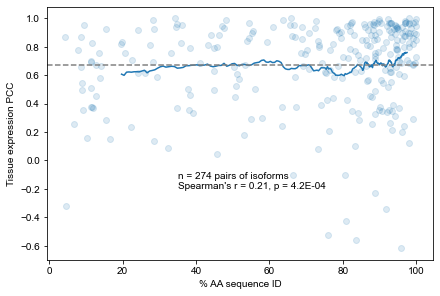

In [19]:
window_size = 50
var_x = 'aa_seq_pct_id'
var_y = 'tissue_expression_pcc'
xy = pairs.loc[pairs[var_x].notnull() &
               pairs[var_y].notnull(),
               [var_x, var_y]].values

fig, ax = plt.subplots(1, 1)
ax.scatter(xy[:, 0], xy[:, 1],
           clip_on=False, 
           alpha=0.15,)
avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull(), :]
        .sort_values(var_x)
        .rolling(window_size, center=True)
        .mean()[[var_x, var_y]]).dropna().values
ax.plot(avrg[:,0], avrg[:, 1])
ax.set_xlabel('% AA sequence ID')
ax.axhline(y=xy[:, 1].mean(), color='grey', linestyle='--')
#ax.set_xlim(0, 100)
#ax.set_ylim(0, 1)
ax.set_ylabel('Tissue expression PCC')
ax.text(s=('n = {} pairs of isoforms'.format(xy.shape[0]) + 
           "\nSpearman's r = {:.2f}, p = {:.1E}".format(*stats.spearmanr(xy[:, 0], xy[:, 1]))),
        x=35, y=-0.2,
        ha='left')
fig.savefig('../figures/{}-vs-{}_scatter-with-moving-average.pdf'.format(var_x, var_y),
            bbox_inches='tight')

In [20]:
m1h = load_m1h_activation_data()
m1h['mean'] = m1h.loc[:, ['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
pairs['m1h_non_zero'] = pairs['gene_symbol'].isin(set(m1h.loc[m1h['mean'].abs() >= 1, 'gene_symbol'].unique()))

<ipython-input-21-80fdc500c489>:14: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Ensembl_gene_ID', 'Ensembl_transcript_IDs_alt',
       'Ensembl_transcript_IDs_ref', 'clone_acc_alt', 'clone_acc_ref',
       'dimer_ppi', 'family', 'gene_symbol', 'other_than_dimer_ppi', 'pair',
       'tf_cofactor_ppi', 'tf_signalling_ppi', 'tf_tf_ppi'],
      dtype='object')
  avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull() & pairs['m1h_non_zero'], :]


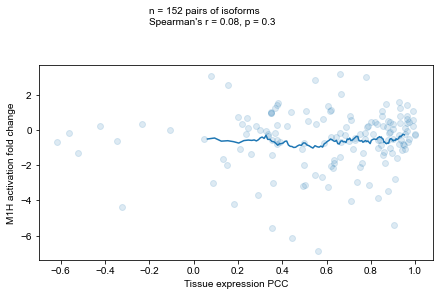

In [21]:
# take M1H data where at least one isoform of a gene is non-zero
window_size = 30
var_x = 'tissue_expression_pcc'
var_y = 'activation_fold_change_log2'
xy = pairs.loc[pairs[var_x].notnull() &
               pairs[var_y].notnull() &
               pairs['m1h_non_zero'],
               [var_x, var_y]].values

fig, ax = plt.subplots(1, 1)
ax.scatter(xy[:, 0], xy[:, 1],
           clip_on=False, 
           alpha=0.15,)
avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull() & pairs['m1h_non_zero'], :]
        .sort_values(var_x)
        .rolling(window_size, center=True)
        .mean()[[var_x, var_y]]).dropna().values
ax.plot(avrg[:,0], avrg[:, 1])
ax.set_xlabel('Tissue expression PCC')
#ax.set_xlim(0, 100)
#ax.set_ylim(0, 1)
ax.set_ylabel('M1H activation fold change')
ax.text(s=('n = {} pairs of isoforms'.format(xy.shape[0]) + 
           "\nSpearman's r = {:.2f}, p = {:.1f}".format(*stats.spearmanr(xy[:, 0], xy[:, 1]))),
        x=-0.2, y=6.,
        ha='left')
fig.savefig('../figures/{}-vs-{}_scatter-with-moving-average_M1H-non-zero-only.pdf'.format(var_x, var_y),
            bbox_inches='tight')

In [22]:
pairs.loc[pairs['m1h_non_zero'], :].sort_values('tissue_expression_pcc').head(10)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_id,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,pair,tissue_expression_pcc,m1h_non_zero
250,RFX4,ENSG00000111783,RFX,True,RFX4|1/3|10C04,RFX4|2/3|10D02,ENST00000392842,NaN,False,True,True,735,706,18,17,False,False,True,False,False,True,False,False,0.0,0.000000,False,95.9,8.0,5.0,8.0,8.0,5.0,5.0,3.0,-3.0,0.625000,retains all,loses some,loses some,loses some,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,True,-0.890237,-1.550829,-0.660592,RFX4|1/3|10C04_RFX4|2/3|10D02,-0.618160,True
251,RFX4,ENSG00000111783,RFX,True,RFX4|1/3|10C04,RFX4|3/3|12B07,ENST00000392842,ENST00000229387,False,False,True,735,641,18,14,True,False,False,False,False,False,False,False,32.0,87.341772,True,83.5,8.0,0.0,8.0,8.0,0.0,0.0,8.0,-8.0,0.000000,NaN,NaN,NaN,NaN,NaN,4.0,0.0,4.0,4.0,0.0,0.0,0.0,True,-0.890237,-1.084610,-0.194373,RFX4|1/3|10C04_RFX4|3/3|12B07,-0.561393,True
227,ZBTB44,ENSG00000196323,C2H2 ZF,False,ZBTB44|1/9|12B06,ZBTB44|4/9|10H06,ENST00000357899|ENST00000397753,NaN,False,True,True,570,436,6,5,False,True,False,True,True,False,False,False,0.0,53.982301,True,76.0,11.0,11.0,17.0,11.0,11.0,5.0,12.0,0.0,0.294118,NaN,loses some,loses some,loses some,gains some,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.222032,-1.102926,-1.324958,ZBTB44|1/9|12B06_ZBTB44|4/9|10H06,-0.523299,True
81,TFDP2,ENSG00000114126,E2F,True,TFDP2|1/4|03C12,TFDP2|4/4|03G11,ENST00000499676,ENST00000495310,False,False,False,418,349,10,9,True,False,True,False,False,True,False,False,0.0,0.000000,False,80.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.581084,2.791939,0.210855,TFDP2|1/4|03C12_TFDP2|4/4|03G11,-0.423937,True
79,TFDP2,ENSG00000114126,E2F,True,TFDP2|1/4|03C12,TFDP2|2/4|11E12,ENST00000499676,ENST00000467072|ENST00000486111,False,False,False,418,386,10,10,True,False,False,False,True,False,False,False,1.0,0.000000,False,91.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.581084,1.955888,-0.625196,TFDP2|1/4|03C12_TFDP2|2/4|11E12,-0.344371,True
222,CREBZF,ENSG00000137504,bZIP,True,CREBZF|1/2|04B03,CREBZF|2/2|04C04,ENST00000527447,ENST00000534224,False,False,True,354,67,1,4,True,True,False,False,False,False,False,False,0.0,100.000000,True,4.5,3.0,0.0,3.0,3.0,0.0,0.0,3.0,-3.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.414345,-0.963108,-4.377453,CREBZF|1/2|04B03_CREBZF|2/2|04C04,-0.323082,True
225,ZBTB44,ENSG00000196323,C2H2 ZF,False,ZBTB44|1/9|12B06,ZBTB44|2/9|10F05,ENST00000357899|ENST00000397753,NaN,False,True,True,570,514,6,5,False,True,True,True,True,True,False,False,0.0,0.000000,False,88.8,11.0,0.0,11.0,11.0,0.0,0.0,11.0,-11.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.222032,0.584124,0.362092,ZBTB44|1/9|12B06_ZBTB44|2/9|10F05,-0.230766,True
80,TFDP2,ENSG00000114126,E2F,True,TFDP2|1/4|03C12,TFDP2|3/4|04B01,ENST00000499676,NaN,False,True,False,418,350,10,9,True,False,True,False,True,True,False,False,1.0,0.000000,False,80.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [23]:
stats.fisher_exact([[113, 65], [35, 25]])

SignificanceResult(statistic=1.2417582417582418, pvalue=0.5386471027282522)

<ipython-input-24-7ca881f09c87>:14: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Ensembl_gene_ID', 'Ensembl_transcript_IDs_alt',
       'Ensembl_transcript_IDs_ref', 'clone_acc_alt', 'clone_acc_ref',
       'family', 'gene_symbol', 'other_than_dimer_ppi', 'pair',
       'tf_cofactor_ppi', 'tf_signalling_ppi', 'tf_tf_ppi'],
      dtype='object')
  avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull() & (pairs['family'] == 'C2H2 ZF'), :]
<ipython-input-24-7ca881f09c87>:32: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Ensembl_gene_ID', 'Ensembl_transcript_IDs_alt',
       'Ensembl_transcript_IDs_ref', 'clone_acc_alt', 'clone_acc_ref',
       'dime

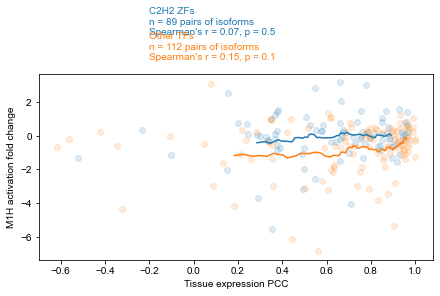

In [24]:
# split ZF
window_size = 30
var_x = 'tissue_expression_pcc'
var_y = 'activation_fold_change_log2'
fig, ax = plt.subplots(1, 1)

xy = pairs.loc[pairs[var_x].notnull() &
               pairs[var_y].notnull() &
               (pairs['family'] == 'C2H2 ZF'),
               [var_x, var_y]].values
ax.scatter(xy[:, 0], xy[:, 1],
           clip_on=False, 
           alpha=0.15,)
avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull() & (pairs['family'] == 'C2H2 ZF'), :]
        .sort_values(var_x)
        .rolling(window_size, center=True)
        .mean()[[var_x, var_y]]).dropna().values
ax.plot(avrg[:,0], avrg[:, 1])
ax.text(s=('C2H2 ZFs\nn = {} pairs of isoforms'.format(xy.shape[0]) + 
           "\nSpearman's r = {:.2f}, p = {:.1f}".format(*stats.spearmanr(xy[:, 0], xy[:, 1]))),
        x=-0.2, y=6.,
        ha='left', color='C0')


xy = pairs.loc[pairs[var_x].notnull() &
               pairs[var_y].notnull() &
               (pairs['family'] != 'C2H2 ZF'),
               [var_x, var_y]].values
ax.scatter(xy[:, 0], xy[:, 1],
           clip_on=False, 
           alpha=0.15,)
avrg = (pairs.loc[pairs[var_x].notnull() & pairs[var_y].notnull() & (pairs['family'] != 'C2H2 ZF'), :]
        .sort_values(var_x)
        .rolling(window_size, center=True)
        .mean()[[var_x, var_y]]).dropna().values
ax.plot(avrg[:,0], avrg[:, 1])
ax.text(s=('Other TFs\nn = {} pairs of isoforms'.format(xy.shape[0]) + 
           "\nSpearman's r = {:.2f}, p = {:.1f}".format(*stats.spearmanr(xy[:, 0], xy[:, 1]))),
        x=-0.2, y=4.5,
        ha='left', color='C1')


ax.set_xlabel('Tissue expression PCC')
#ax.set_xlim(0, 100)
#ax.set_ylim(0, 1)
ax.set_ylabel('M1H activation fold change')
fig.savefig('../figures/{}-vs-{}_scatter-with-moving-average_split-ZF.pdf'.format(var_x, var_y),
            bbox_inches='tight')

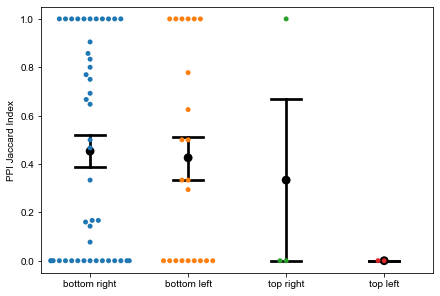

In [25]:
pairs['expression_activation_category'] = np.nan
pairs.loc[(pairs['tissue_expression_pcc'] >= 0.6) &
          (pairs['activation_fold_change_log2'] >= 1), 'expression_activation_category'] = 'top right'
pairs.loc[(pairs['tissue_expression_pcc'] >= 0.6) &
          (pairs['activation_fold_change_log2'] < 1), 'expression_activation_category'] = 'bottom right'
pairs.loc[(pairs['tissue_expression_pcc'] < 0.6) &
          (pairs['activation_fold_change_log2'] < 1), 'expression_activation_category'] = 'bottom left'
pairs.loc[(pairs['tissue_expression_pcc'] < 0.6) &
          (pairs['activation_fold_change_log2'] >= 1), 'expression_activation_category'] = 'top left'
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=pairs, x='expression_activation_category', y='PPI_jaccard', ax=ax)
sns.pointplot(data=pairs, x='expression_activation_category', y='PPI_jaccard', ax=ax,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',)
ax.set_ylabel('PPI Jaccard Index')
ax.set_xlabel('')
plt.savefig('../figures/PPI-Jaccard_by-expression-and-activation-category.pdf',
            bbox_inches='tight')

In [26]:
pairs['expression_activation_category'].value_counts()

bottom right    121
bottom left      58
top right        13
top left          9
Name: expression_activation_category, dtype: int64

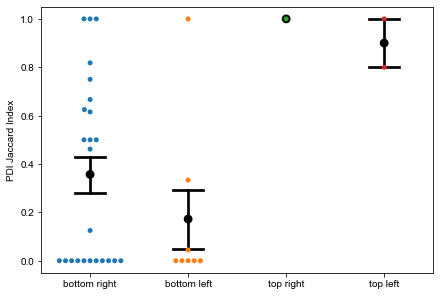

In [27]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=pairs, x='expression_activation_category', y='PDI_jaccard', ax=ax)
sns.pointplot(data=pairs, x='expression_activation_category', y='PDI_jaccard', ax=ax,
              color='black',
              ci=68,
              capsize=0.3,
              linestyles='',)
ax.set_ylabel('PDI Jaccard Index')
ax.set_xlabel('')
plt.savefig('../figures/PDI-Jaccard_by-expression-and-activation-category.pdf',
            bbox_inches='tight')

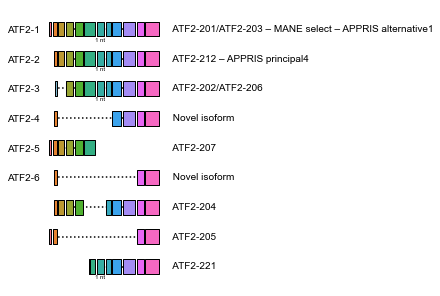

In [28]:
# add categories to pairs
tfs['ATF2'].exon_diagram()

In [29]:
for i in range(2, 7):
    print('ATF2-{}'.format(i))
    if tfs['ATF2'].alternative_start('ATF2-1', 'ATF2-{}'.format(i)):
        print('Alternative start')
    if tfs['ATF2'].alternative_stop('ATF2-1', 'ATF2-{}'.format(i)):
        print('Alternative stop')
    if tfs['ATF2'].alternative_internal_exon('ATF2-1', 'ATF2-{}'.format(i)):
        print('Alternative internal exon')
    if tfs['ATF2'].alternative_3prime_acceptor('ATF2-1', 'ATF2-{}'.format(i)):
        print('Alternative 3 prime')
    if tfs['ATF2'].alternative_5prime_donor('ATF2-1', 'ATF2-{}'.format(i)):
        print('Alternative 5 prime')
    print()

ATF2-2
Alternative start
Alternative 3 prime

ATF2-3
Alternative start
Alternative internal exon
Alternative 3 prime

ATF2-4
Alternative start
Alternative internal exon
Alternative 3 prime

ATF2-5
Alternative stop
Alternative 5 prime

ATF2-6
Alternative start
Alternative internal exon
Alternative 3 prime



In [30]:
pairs['iso_cat'] = 'both'
pairs.loc[(pairs['is_alternative_internal_exon'] == False) 
          & pairs['is_alternative_N_terminal'], 
          'iso_cat'] = 'alternative N terminal'
pairs.loc[pairs['is_alternative_internal_exon'] 
          & (pairs['is_alternative_N_terminal'] == False), 
          'iso_cat'] = 'alternative internal exon'

In [31]:
pairs['iso_cat'].value_counts()

both                         202
alternative N terminal       139
alternative internal exon    106
Name: iso_cat, dtype: int64

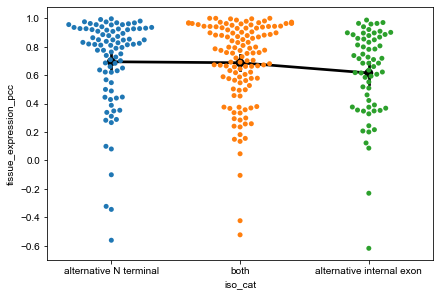

In [32]:
sns.pointplot(data=pairs, x='iso_cat', y='tissue_expression_pcc', color='black')
sns.swarmplot(data=pairs, x='iso_cat', y='tissue_expression_pcc')
plt.savefig('../figures/tissue_pcc_by_isoform_category.pdf', bbox_inches='tight')

In [33]:
print(cloned.sum(), similarities.loc[cloned, 'PCC_corrected'].notnull().sum())

803 395


<AxesSubplot: ylabel='Frequency'>

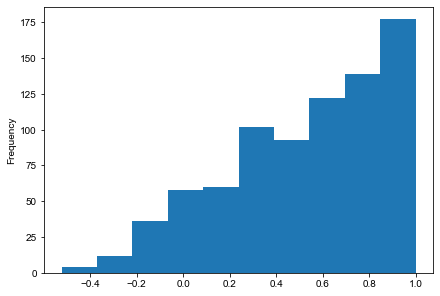

In [34]:
similarities['PCC'].plot.hist()

<AxesSubplot: ylabel='Frequency'>

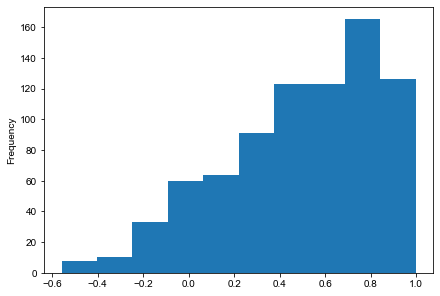

In [35]:
similarities['Spearmans'].plot.hist()

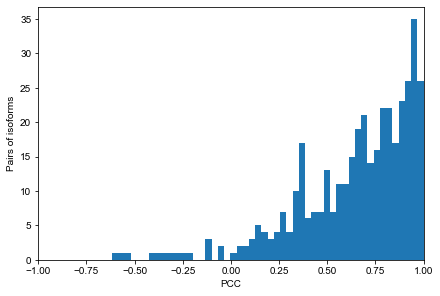

In [36]:
similarities.loc[cloned, 'PCC_corrected'].plot.hist(bins=50)
plt.ylabel('Pairs of isoforms')
plt.xlabel('PCC')
plt.xlim(-1, 1)
plt.savefig('../figures/tissue-expression-PCC_per-cloned-isoform-pair.pdf',
            bbox_inches='tight')

<ipython-input-37-16a96c9fe3b1>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.text(s='PCC = {:.2f}'.format(similarities.corr().loc['min_max_tpm', 'PCC_corrected']),


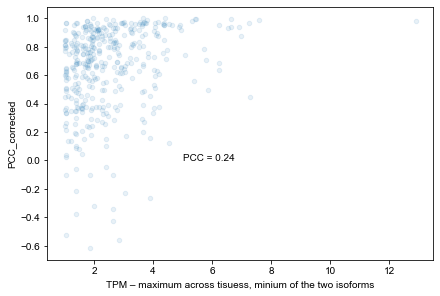

In [37]:
# plot corrected PCC vs minimum maximum TPM
similarities['max_tpm_a'] = similarities['iso_a'].map(means.max(axis=1))
similarities['max_tpm_b'] = similarities['iso_b'].map(means.max(axis=1))
similarities['min_max_tpm'] = similarities[['max_tpm_a', 'max_tpm_b']].min(axis=1)
similarities.plot.scatter(x='min_max_tpm', y='PCC_corrected', alpha=0.1)
plt.xlabel('TPM – maximum across tisuess, minium of the two isoforms')
plt.text(s='PCC = {:.2f}'.format(similarities.corr().loc['min_max_tpm', 'PCC_corrected']),
         x=5, y=0)
plt.savefig('../figures/tissue-expression-PCC-vs-min-max-tpm.pdf',
            bbox_inches='tight')

<ipython-input-38-9f91d75cd2f2>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.text(s='PCC = {:.2f}'.format(similarities.corr().loc['min_max_tpm', 'PCC']),


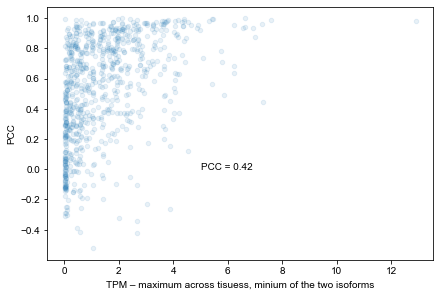

In [38]:
# plot corrected PCC vs minimum maximum TPM
similarities['max_tpm_a'] = similarities['iso_a'].map(means.max(axis=1))
similarities['max_tpm_b'] = similarities['iso_b'].map(means.max(axis=1))
similarities['min_max_tpm'] = similarities[['max_tpm_a', 'max_tpm_b']].min(axis=1)
similarities.plot.scatter(x='min_max_tpm', y='PCC', alpha=0.1)
plt.xlabel('TPM – maximum across tisuess, minium of the two isoforms')

plt.text(s='PCC = {:.2f}'.format(similarities.corr().loc['min_max_tpm', 'PCC']),
         x=5, y=0)
plt.savefig('../figures/tissue-expression-raw-PCC-vs-min-max-tpm.pdf')

In [39]:
# pick some examples
similarities.sort_values('PCC_corrected').head(30)

,iso_a,iso_b,PCC,Spearmans,PCC_corrected,pair,max_tpm_a,max_tpm_b,min_max_tpm
2065,RFX4|1/3|10C04 RFX4-203,RFX4|2/3|10D02 nomatch,0.507514,0.676689,-0.618160,RFX4|1/3|10C04_RFX4|2/3|10D02,2.856798,1.860757,1.860757
2066,RFX4|1/3|10C04 RFX4-203,RFX4|3/3|12B07 RFX4-201,0.770096,0.761635,-0.561393,RFX4|1/3|10C04_RFX4|3/3|12B07,2.856798,6.059361,2.856798
3148,ZBTB44|1/9|12B06 ZBTB44-201_ZBTB44-202,ZBTB44|4/9|10H06 nomatch,-0.523299,-0.350632,-0.523299,ZBTB44|1/9|12B06_ZBTB44|4/9|10H06,3.045867,1.049256,1.049256
2830,TFDP2|1/4|03C12 TFDP2-224,TFDP2|4/4|03G11 TFDP2-222,-0.423937,-0.274328,-0.423937,TFDP2|1/4|03C12_TFDP2|4/4|03G11,2.654948,2.695152,2.654948
3044,TP63|2/3|01D01 TP63-210,TP63|3/3|07D09 TP63-212,-0.036176,0.255352,-0.376125,TP63|2/3|01D01_TP63|3/3|07D09,1.374607,2.497961,1.374607
2828,TFDP2|1/4|03C12 TFDP2-224,TFDP2|2/4|11E12 TFDP2-202_TFDP2-212,-0.344371,-0.144120,-0.344371,TFDP2|1/4|03C12_TFDP2|2/4|11E12,2.654948,5.048852,2.654948
131,CREBZF|1/2|04B03 CREBZF-204,CREBZF|2/2|04C04 CREBZF-209,-0.323082,-0.239261,-0.323082,CREBZF|1/2|04B03_CREBZF|2/2|04C04,4.781940,2.015676,2.015676
3774,ZNF655|3/6|03B05 ZNF655-202,ZNF655|4/6|03C06 ZNF655-203_ZNF655-215,-0.262798,-0.198323,-0.262798,ZNF655|3/6|03B05_ZNF655|4/6|03C06,4.050428,3.890054,3.890054
3146,ZBTB44|1/9|12B06 ZBTB44-201_ZBTB44-202,ZBTB44|2/9|10F05 nomatch,-0.230766,-0.240328,-0.230766,ZBTB44|1/9|12B06_ZBTB44|2/9|10F05,3.045867,3.139867,3.045867
1049,KLF7|3/8|10B10 KLF7-202,KLF7|5/8|11H02 KLF7-204,-0.196936,-0.116371,-0.218456,KLF7|3/8|10B10_KLF7|5/8|11H02,2.725918,1.400847,1.400847


In [40]:
from pathlib import Path

<ipython-input-41-40a05076d332>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_yticklabels(['{:.0%}'.format(t) for t in axes[3].get_yticks()])
<ipython-input-41-40a05076d332>:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


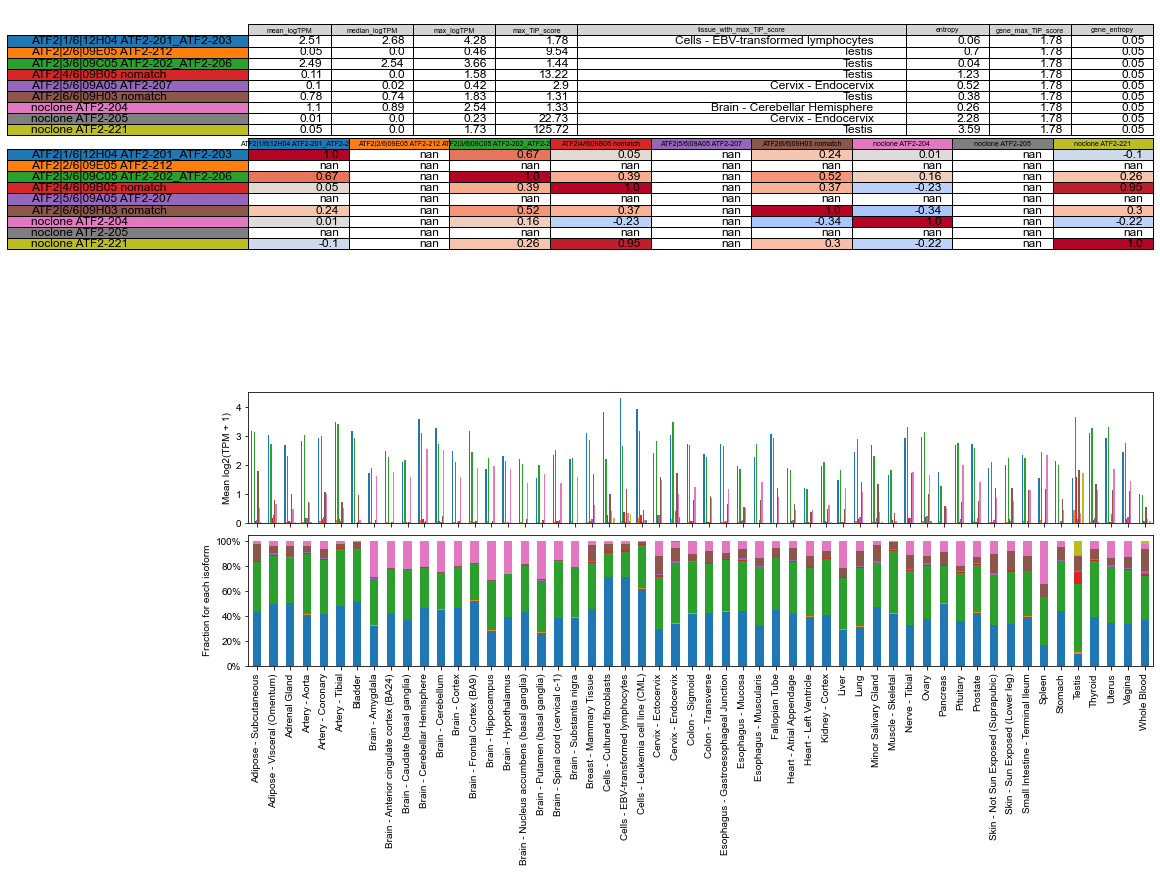

In [41]:
# make a plot of per gene pairwise correlations vs levels 
def table_and_graphs(gene_name):
    fig, axes = plt.subplots(4, 1, sharex=True)
    fig.set_size_inches(16, 12)
    ### table ###
    ncol = iso.shape[1] - 1
    data = iso.loc[iso['gene_symbol'] == gene_name, 
                   filter(lambda x: x != 'gene_symbol', iso.columns)].copy()
    data.index = data.index.str.replace('GC grp: ', '').str.replace('|' + gene_name+ '-', '/', regex=False)
    tab = pd.plotting.table(ax=axes[0],
                            data=data.round(2),
                            loc='lower center',
                            rowColours=['C' + str(i) for i in range((iso['gene_symbol'] == gene_name).sum())],
                            colColours=['lightgrey'] * ncol,
                            fontsize=32,
                            colWidths=[4 / (ncol + 3) if i == 4 else 1 / (ncol + 3) for i in range(ncol)])
    tab.auto_set_font_size(False)
    tab.set_fontsize(12)
    axes[0].axis('off')
    for key, cell in tab.get_celld().items():
        if key[0] == 0:
            cell.set_fontsize(7)
    ### pairwise similarity ###
    # TODO: - format names
    vals = means.loc[genes == gene_name, :].copy()
    vals.loc[:, vals.sum(axis=0) < 1] = np.nan
    vals.loc[(vals >= 1).sum(axis=1) == 0, :] = np.nan
    corr = vals.T.corr()
    #corr = means.loc[genes == gene_name, :].T.corr()
    corr.index = corr.index.str.replace('GC grp: ', '').str.replace('|' + gene_name + '-', '/', regex=False)
    corr.columns = corr.columns.str.replace('GC grp: ', '').str.replace('|' + gene_name + '-', '/', regex=False)
    tab2 = pd.plotting.table(ax=axes[0],  # NOTE this should be axes[1] but not working that way for some confusing reason...
                             data=corr.round(2),
                             cellColours=plt.cm.coolwarm(plt.Normalize(vmin=-1, vmax=1)(corr.values)),  # NOTE: don't know if correct! want vmin=-1, vmax=1
                             rowColours=['C' + str(i) for i in range((iso['gene_symbol'] == gene_name).sum())],
                             colColours=['C' + str(i) for i in range((iso['gene_symbol'] == gene_name).sum())],
                             fontsize=32)
    tab2.auto_set_font_size(False)
    tab2.set_fontsize(12)
    axes[1].axis('off')
    for key, cell in tab2.get_celld().items():
        if key[0] == 0:
            cell.set_fontsize(7)
    ### bar chart ###
    (means.loc[genes == gene_name, :]
          .T
          .plot.bar(ax=axes[2],
                    legend=False,
                    width=0.7))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[3], 
                          stacked=True,
                          legend=False))
    axes[2].set_ylabel('Mean log2(TPM + 1)')
    #axes[0].set_title(gene_name)
    axes[3].set_ylabel('Fraction for each isoform')
    axes[3].set_yticklabels(['{:.0%}'.format(t) for t in axes[3].get_yticks()])
    plt.subplots_adjust(hspace=0.05)
    fig_dir = Path('../figures/tissue_expression_per_gene')
    fig_dir.mkdir(exist_ok=True)
    plt.savefig(fig_dir / (gene_name + '_tissue_expression.pdf'),
                bbox_inches='tight')

table_and_graphs('ATF2')

In [42]:
means = means.loc[sorted(means.index.values, key=lambda x: (x.startswith('noclone'), x)), :]

def presentable_names(s):
    clones, ensembls = s.split(' ')
    if clones == 'noclone':
        a = 'not cloned'
    else:
        a = '/'.join([x.split('|')[0] + '-' + x.split('|')[1].split('/')[0] for x in clones.split('_')])
    if ensembls == 'nomatch':
        b = ' novel isoform'
    else:
        b = '/'.join(ensembls.split('_'))
    return a + ' – ' + b


means.index = means.index.map(presentable_names)
genes.index = genes.index.map(presentable_names)

In [43]:
similarities['iso_a'] = similarities['iso_a'].map(presentable_names)
similarities['iso_b'] = similarities['iso_b'].map(presentable_names)

In [44]:
genes.nunique()

309

In [45]:
# TODO: this should be already in the website notebook
def tissue_expression_plot(gene_name, means=means):
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(12, 6)
    ### bar chart ###
    (means.loc[genes == gene_name, :]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False))
    axes[0].set_ylabel('Mean log2(TPM + 1)')
    axes[1].set_ylabel('Fraction for each isoform')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.subplots_adjust(hspace=0.05)
    fig_dir = Path('/Users/lukelambourne/Dropbox (Partners HealthCare)/TF_isoforms/TF_gene_summary_pages/media')
    plt.savefig(fig_dir / (gene_name + '_tissue-expression.svg'),
                bbox_inches='tight')

for tf in genes.unique():
    break   # TMP
    tissue_expression_plot(tf)
    plt.close(plt.gcf())

In [46]:
similarities['gene_symbol'] = similarities['iso_a'].map(genes)
similarities['family'] = similarities['gene_symbol'].map(tf_fam)
similarities.loc[cloned, :].head()

,iso_a,iso_b,PCC,Spearmans,PCC_corrected,pair,max_tpm_a,max_tpm_b,min_max_tpm,gene_symbol,family
0,AEBP2-2 – novel isoform,AEBP2-3 – novel isoform,0.761984,0.827864,NaN,AEBP2|2/3|05F03_AEBP2|3/3|05E07,2.074463,0.559758,0.559758,AEBP2,C2H2 ZF
15,ARNT2-1 – ARNT2-201,ARNT2-2 – novel isoform,0.854209,0.858499,NaN,ARNT2|1/6|08C12_ARNT2|2/6|09E01,6.134232,0.211308,0.211308,ARNT2,bHLH
16,ARNT2-1 – ARNT2-201,ARNT2-3 – ARNT2-209,0.619284,0.321099,NaN,ARNT2|1/6|08C12_ARNT2|3/6|10D11,6.134232,0.886964,0.886964,ARNT2,bHLH
18,ARNT2-2 – novel isoform,ARNT2-3 – ARNT2-209,0.582790,0.384444,NaN,ARNT2|2/6|09E01_ARNT2|3/6|10D11,0.211308,0.886964,0.211308,ARNT2,bHLH
21,ARNTL2-1 – novel isoform,ARNTL2-2 – ARNTL2-204,0.930272,0.657760,NaN,ARNTL2|1/5|10H01_ARNTL2|2/5|12C06,0.854570,1.586340,0.854570,ARNTL2,bHLH


In [47]:
similarities.loc[cloned & similarities['PCC_corrected'].notnull(), :].groupby('family').size().sort_values(ascending=False)

family
C2H2 ZF             164
bHLH                 43
Homeodomain          24
Nuclear receptor     23
bZIP                 18
Ets                  14
SMAD                 12
THAP finger          11
HMG/Sox               9
E2F                   8
Grainyhead            7
RFX                   6
AP-2                  6
EBF1                  6
STAT                  5
p53                   4
IRF                   4
T-box                 4
Paired box            4
Forkhead              3
C2H2 ZF; AT hook      3
Myb/SANT              3
TEA                   2
GATA                  2
Rel                   2
CSL                   1
CxxC                  1
MADS box              1
TBP                   1
AT hook               1
CCCH ZF               1
CBF/NF-Y              1
HSF                   1
dtype: int64

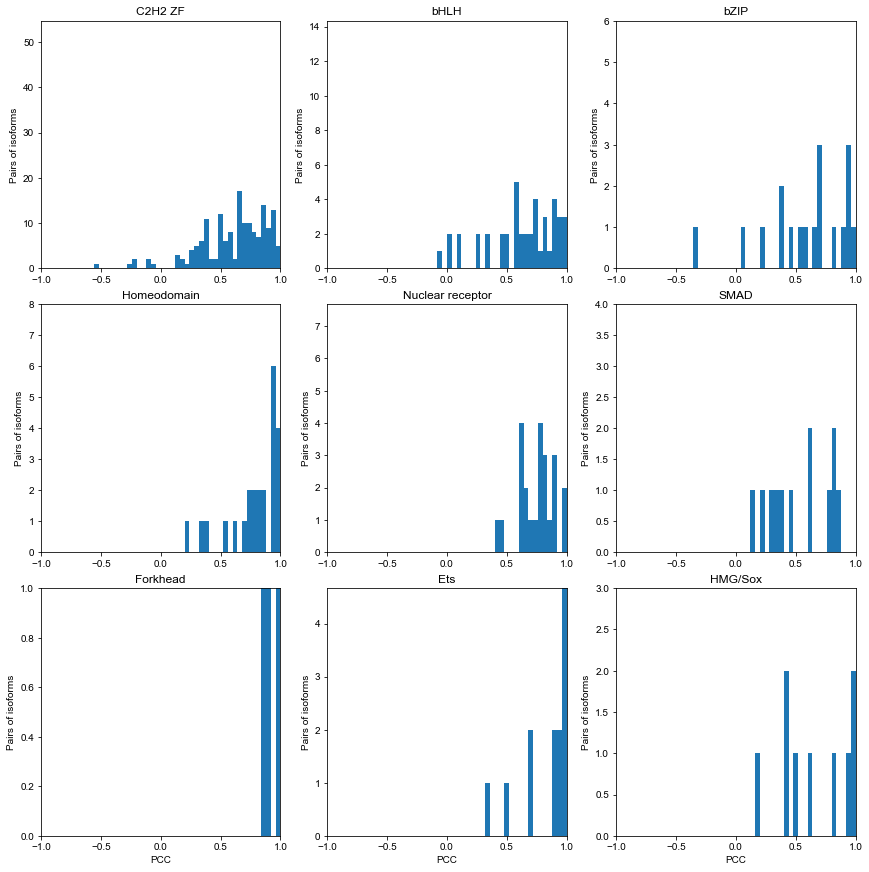

In [48]:
families = ['C2H2 ZF', 'bHLH', 'bZIP',  'Homeodomain',  'Nuclear receptor', 'SMAD', 'Forkhead', 'Ets', 'HMG/Sox',]
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(12, 12)
for family, ax in zip(families, axs.flatten()):
    ax.set_title(family)
    similarities.loc[cloned & (similarities['family'] == family), 'PCC_corrected'].plot.hist(bins=50, range=(-1, 1), ax=ax)
    n = (cloned & (similarities['family'] == family) & similarities['PCC_corrected'].notnull()).sum()
    ax.set_ylabel('Pairs of isoforms')
    ax.set_xlabel('PCC')
    ax.set_xlim(-1, 1)
    ax.set_ylim(0, n/3)
    ax.set_xlabel('')
for ax in axs[-1, :]:
    ax.set_xlabel('PCC')
plt.savefig('../figures/tissue-expression-PCC_per-cloned-isoform-pair_by-TF-family.pdf',
            bbox_inches='tight')
    

<ipython-input-41-40a05076d332>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_yticklabels(['{:.0%}'.format(t) for t in axes[3].get_yticks()])
<ipython-input-41-40a05076d332>:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


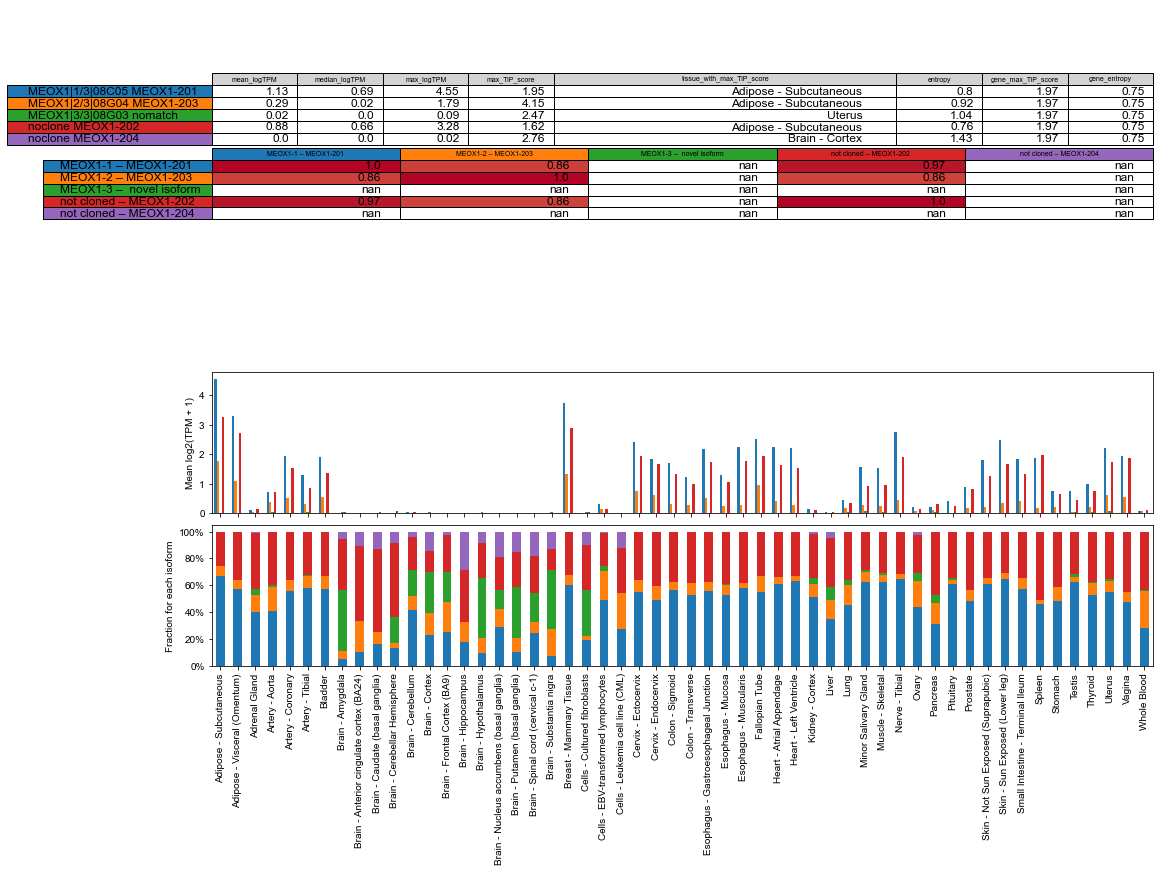

In [49]:
table_and_graphs('MEOX1')

<ipython-input-41-40a05076d332>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_yticklabels(['{:.0%}'.format(t) for t in axes[3].get_yticks()])
<ipython-input-41-40a05076d332>:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


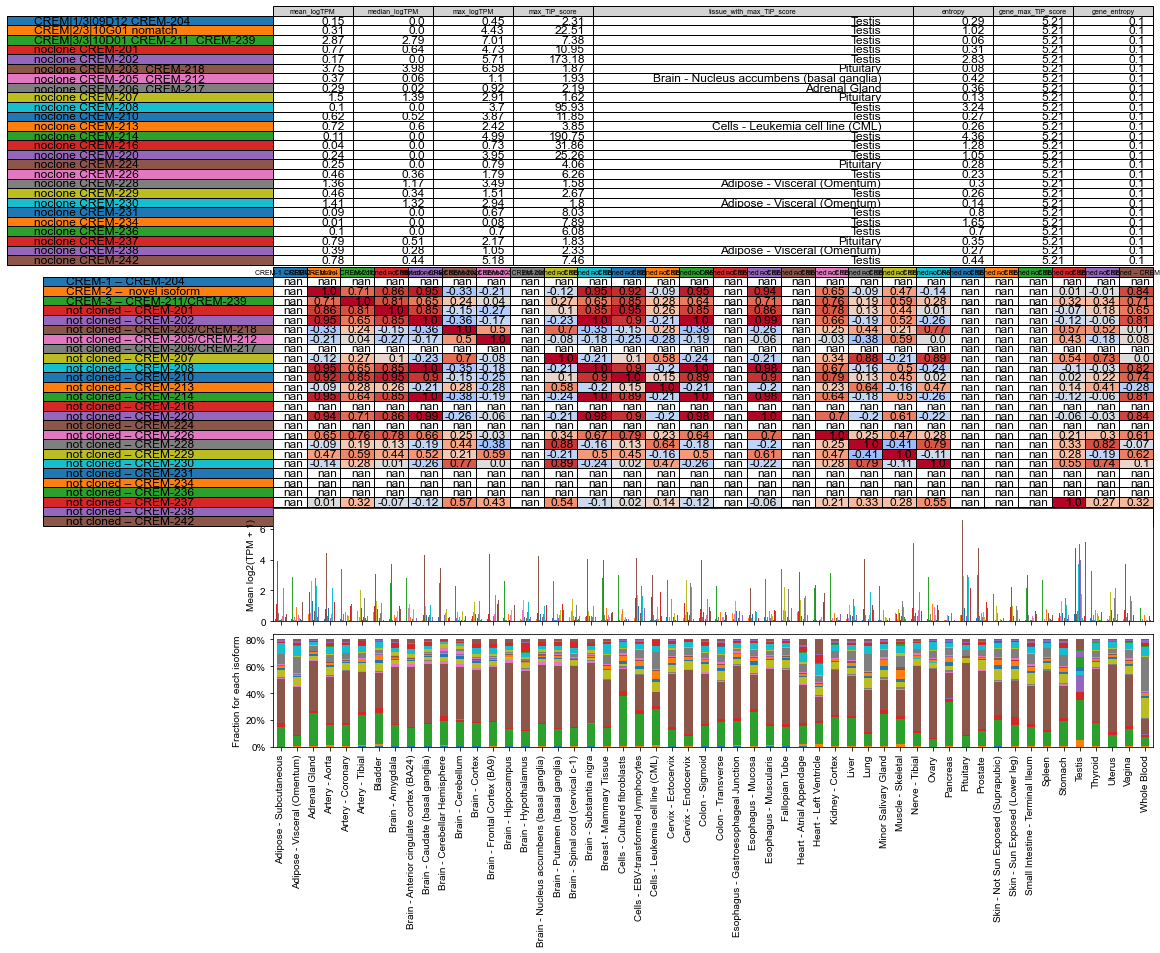

In [50]:
table_and_graphs('CREM')

<ipython-input-41-40a05076d332>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[3].set_yticklabels(['{:.0%}'.format(t) for t in axes[3].get_yticks()])
<ipython-input-41-40a05076d332>:60: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


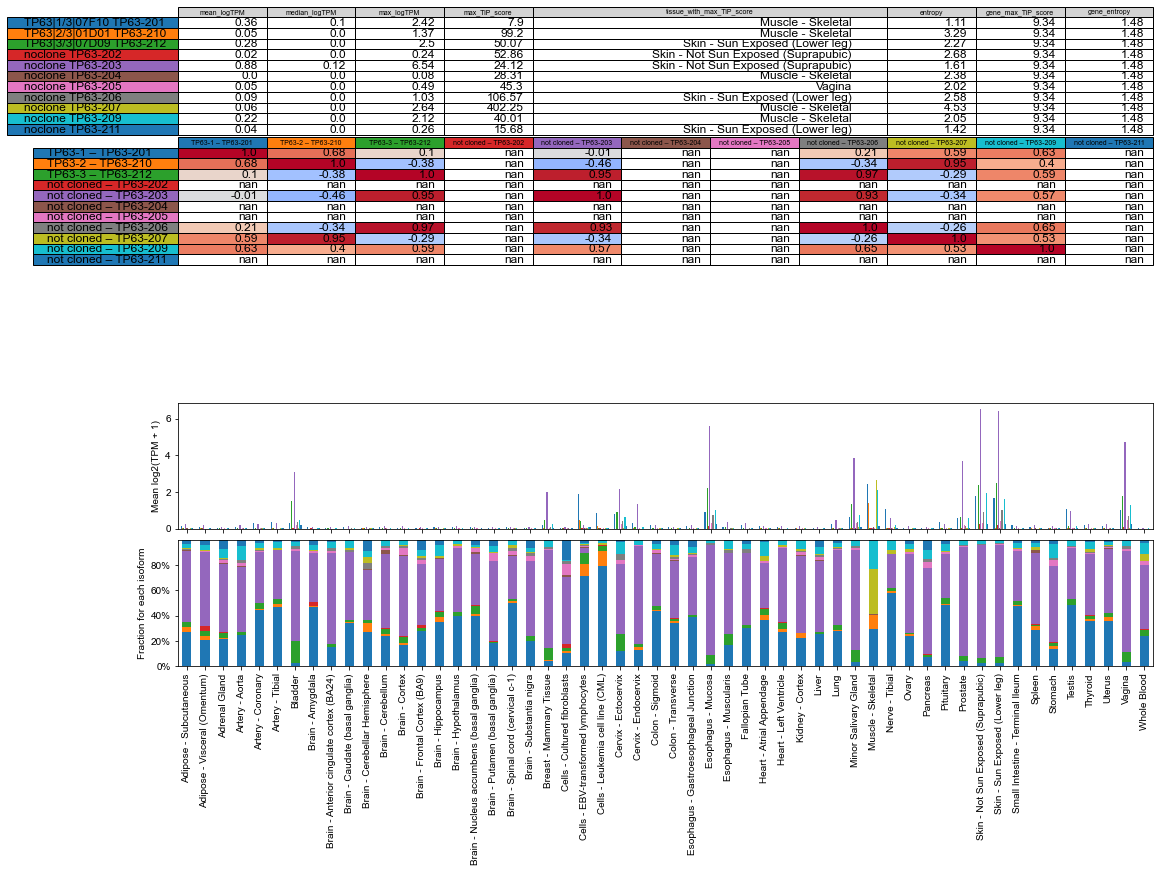

In [51]:
table_and_graphs('TP63')

In [52]:
len(means.columns)

54

309 total TF genes in dataset
304 genes with TPM > 1
981 isoforms with TPM > 1
270 genes with ≥ 2 isoforms with TPM > 1


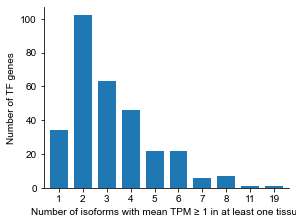

In [53]:
print(genes.nunique(), 'total TF genes in dataset')
print(genes[means.max(axis=1) > 1.].nunique(), 'genes with TPM > 1')
print(genes[means.max(axis=1) > 1.].shape[0], 'isoforms with TPM > 1')
print((genes[means.max(axis=1) > 1.].value_counts() >= 2).sum(), 'genes with ≥ 2 isoforms with TPM > 1')
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 3)
genes[means.max(axis=1) > 1.].value_counts().value_counts().sort_index().plot.bar(rot=0,
                                                                     width=0.75,
                                                                     ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Number of TF genes')
ax.set_xlabel('Number of isoforms with mean TPM ≥ 1 in at least one tissue')
plt.savefig('../figures/number_of_isoforms_gt_1TPM_per_tf_gene_GTEx.pdf',
            bbox_inches='tight')
# NOTE: add break onto x-axis in Illustrator

In [54]:
def number_dominant_isoforms_across_all_tissues(rows):
    n_isoforms = rows.shape[0]
    if n_isoforms == 0:
        return 0
    if n_isoforms == 1:
        if (rows >= 1.).any().any():
            return 1
        else:
            return 0
    dom_per_tissue = [dominant_isoform_in_tissue(rows[c]) for c in rows.columns]
    return len({iso_id for iso_id in dom_per_tissue if iso_id is not None})


def dominant_isoform_in_tissue(column):
    """Dominant isoform: TPM > 1 and 2-fold more expressed than second most expressed"""
    isoforms_ordered = column.sort_values(ascending=False)
    if isoforms_ordered.iloc[1] == 0:
        fold_change_1st_over_2nd = np.inf
    else:
        fold_change_1st_over_2nd = (2**isoforms_ordered.iloc[0] - 1) / (2**isoforms_ordered.iloc[1] - 1)
    if (isoforms_ordered.iloc[0] >= 1.) and fold_change_1st_over_2nd >= 2:
        return isoforms_ordered.index[0]
    else:
        return None
    

n_dom_per_iso = means.groupby(genes).apply(number_dominant_isoforms_across_all_tissues)
n_dom = n_dom_per_iso.value_counts().sort_index()
print(n_dom)
n_dom = n_dom[n_dom.index > 0]

0     16
1    249
2     40
3      4
dtype: int64


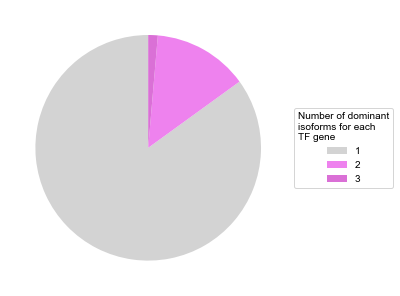

In [55]:
# make it look nicer
fig, ax = plt.subplots(1, 1)
n_dom.plot.pie(startangle=90,
               label='',
               labels=None,
               colors=['lightgrey', 'violet', 'orchid', 'magenta', 'purple'])
ax.legend(n_dom.index,
          loc='center left',
          bbox_to_anchor=[1, 0.5],
          title='Number of dominant\nisoforms for each\nTF gene')
plt.savefig('../figures/dominant_isoforms_pie.pdf',
            bbox_inches='tight')

In [56]:
n_dom.head()

1    249
2     40
3      4
dtype: int64

In [57]:
n_dom_per_iso.sort_values().tail()

TP63      2
TFDP2     3
ZNF655    3
MEIS3     3
TCF12     3
dtype: int64

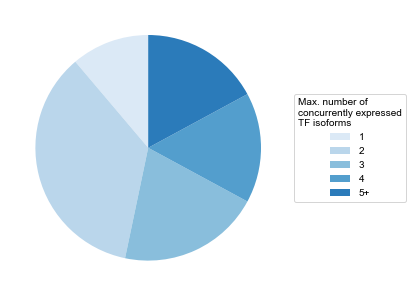

In [58]:
fig, ax = plt.subplots(1, 1)
coexp_iso = (means >= 1.).groupby(genes).sum().max(axis=1).value_counts().sort_index()
data_to_plot = {}
for i in range(1, 5):
    data_to_plot[str(i)] = coexp_iso[i]
data_to_plot['5+'] = coexp_iso.loc[coexp_iso.index >= 5].sum()
ax.pie(data_to_plot.values(),
       colors=sns.color_palette("Blues"),
       startangle=90)
ax.legend(data_to_plot.keys(),
          loc='center left',
          bbox_to_anchor=[1, 0.5],
          title='Max. number of\nconcurrently expressed\nTF isoforms')
plt.savefig('../figures/coexpressed_isoforms_pie.pdf',
            bbox_inches='tight')

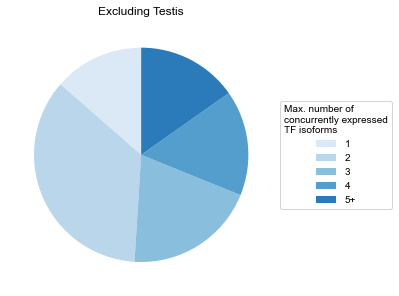

In [59]:
fig, ax = plt.subplots(1, 1)
coexp_iso = (means.loc[:, filter(lambda x: x != 'Testis', means.columns)] >= 1.).groupby(genes).sum().max(axis=1).value_counts().sort_index()
data_to_plot = {}
for i in range(1, 5):
    data_to_plot[str(i)] = coexp_iso[i]
data_to_plot['5+'] = coexp_iso.loc[coexp_iso.index >= 5].sum()
ax.pie(data_to_plot.values(),
       colors=sns.color_palette("Blues"),
       startangle=90)
ax.legend(data_to_plot.keys(),
          loc='center left',
          bbox_to_anchor=[1, 0.5],
          title='Max. number of\nconcurrently expressed\nTF isoforms')
ax.set_title('Excluding Testis')
plt.savefig('../figures/coexpressed_isoforms_pie_excluding_testis.pdf',
            bbox_inches='tight')

In [60]:
iso.sort_values('max_TiP_score', ascending=False).head()

,gene_symbol,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy
UID,,,,,,,,,
noclone NFATC1-205,NFATC1,0.000499,0.0,0.019403,inf,Cells - Cultured fibroblasts,4.643620,1.468767,0.203139
noclone PAX5-206,PAX5,0.007111,0.0,0.188634,inf,Artery - Coronary,3.642694,90.781092,2.329220
noclone TCF4-231,TCF4,0.001145,0.0,0.033814,inf,Adipose - Visceral (Omentum),4.488215,2.337157,0.264529
noclone ETV2-207,ETV2,0.000508,0.0,0.020467,inf,Heart - Atrial Appendage,4.809709,15.325428,0.569106
noclone MEF2A-207,MEF2A,0.007988,0.0,0.274361,inf,Cells - Leukemia cell line (CML),4.412250,1.685358,0.061651


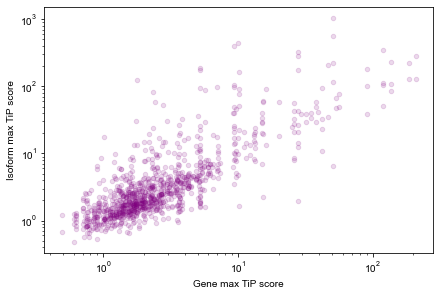

In [61]:
fig, ax = plt.subplots(1, 1)
(iso.loc[iso['max_logTPM'] > 1, :]
    .plot.scatter(x='gene_max_TiP_score',
                  y='max_TiP_score',
                  alpha=0.15,
                  color='purple',
                  ax=ax))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Isoform max TiP score')
ax.set_xlabel('Gene max TiP score')
plt.savefig('../figures/isoform_vs_gene_TiP_score_scatter.pdf',
            bbox_inches='tight')

In [62]:
# theres a problem with infs in the TiP score
# a pseudo count wont help because it's in the IQR that's the problem 
# inspect inf values
(iso.loc[(iso['max_logTPM'] > 1) & 
         (iso['max_TiP_score'] == np.inf), :]
    .sort_values('max_TiP_score', ascending=False).head(60))

,gene_symbol,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy
UID,,,,,,,,,
NFIX|3/4|08F05 nomatch,NFIX,0.022876,0.0,1.229621,inf,Cells - EBV-transformed lymphocytes,5.708127,1.580626,0.119238
SPIB|2/2|07A11 SPIB-206,SPIB,0.117918,0.0,4.340902,inf,Adrenal Gland,4.314730,27.826053,0.899358


In [63]:
iso['TiP_diff'] = iso['max_TiP_score'] - iso['gene_max_TiP_score']
(iso.loc[(iso['max_logTPM'] > 1), :]
    .sort_values('TiP_diff', ascending=False).head(30))

,gene_symbol,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy,TiP_diff
UID,,,,,,,,,,
SPIB|2/2|07A11 SPIB-206,SPIB,0.117918,0.0,4.340902,inf,Adrenal Gland,4.314730,27.826053,0.899358,inf
NFIX|3/4|08F05 nomatch,NFIX,0.022876,0.0,1.229621,inf,Cells - EBV-transformed lymphocytes,5.708127,1.580626,0.119238,inf
noclone HNF4A-204,HNF4A,0.144500,0.0,2.308919,1044.761362,Liver,3.256217,50.526702,1.844619,994.234660
HNF4A|2/6|10H07 HNF4A-202,HNF4A,0.098758,0.0,1.406222,571.192879,Colon - Transverse,2.899826,50.526702,1.844619,520.666177
noclone IKZF2-201,IKZF2,0.039121,0.0,1.725351,450.299558,Cells - EBV-transformed lymphocytes,4.528131,10.000483,0.495165,440.299075
noclone TP63-207,TP63,0.057024,0.0,2.639277,402.246115,Muscle - Skeletal,4.525325,9.337368,1.481115,392.908748
noclone SPIB-201,SPIB,0.302920,0.0,5.857828,320.278889,Cells - EBV-transformed lymphocytes,3.197053,27.826053,0.899358,292.452836
noclone SPIB-207,SPIB,0.126745,0.0,3.799619,287.994495,Cells - EBV-transformed lymphocytes,3.640249,27.826053,0.899358,260.168442
SOX30|2/2|09C11 nomatch,SOX30,0.105452,0.0,4.956750,348.604963,Testis,4.525182,118.211909,2.782569,230.393055


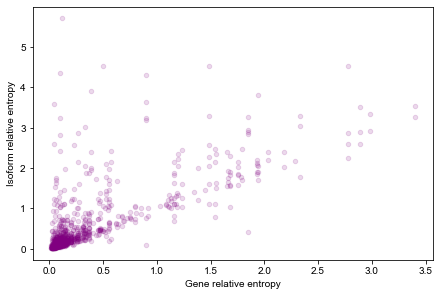

In [64]:
fig, ax = plt.subplots(1, 1)
(iso.loc[iso['max_logTPM'] > 1, :]
    .plot.scatter(x='gene_entropy',
                  y='entropy',
                  alpha=0.15,
                  color='purple',
                  ax=ax))
ax.set_ylabel('Isoform relative entropy')
ax.set_xlabel('Gene relative entropy')
plt.savefig('../figures/isoform_vs_gene_entropy_scatter.pdf',
            bbox_inches='tight')

In [65]:
iso['entropy_diff'] = iso['entropy'] - iso['gene_entropy']
(iso.loc[(iso['max_logTPM'] > 1), :]
    .sort_values('entropy_diff', ascending=False).head())

,gene_symbol,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy,TiP_diff,entropy_diff
UID,,,,,,,,,,,
NFIX|3/4|08F05 nomatch,NFIX,0.022876,0.0,1.229621,inf,Cells - EBV-transformed lymphocytes,5.708127,1.580626,0.119238,inf,5.588889
noclone CREM-214,CREM,0.110146,0.0,4.989521,190.747543,Testis,4.355871,5.214191,0.097398,185.533352,4.258473
noclone IKZF2-201,IKZF2,0.039121,0.0,1.725351,450.299558,Cells - EBV-transformed lymphocytes,4.528131,10.000483,0.495165,440.299075,4.032966
noclone ATF2-221,ATF2,0.049805,0.0,1.727089,125.719173,Testis,3.592857,1.780017,0.045165,123.939157,3.547691
SOX6|3/7|07B08 SOX6-211,SOX6,0.039143,0.0,1.629897,165.381664,Testis,3.909962,10.087135,0.385080,155.294529,3.524881


In [66]:
# entropy per gene per tissue
entropy_per_tissue = pd.DataFrame(data=[means[c].groupby(genes).apply(stats.entropy, base=2) for c in means.columns]).T

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0, 0.5, 'Entropy per TF gene')

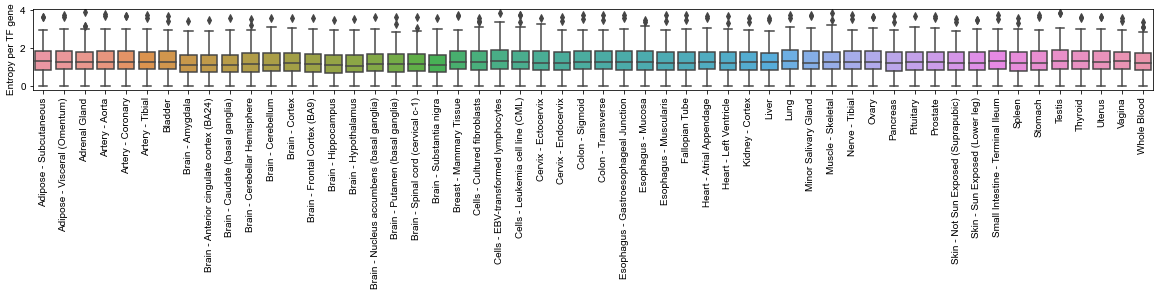

In [67]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.boxplot(data=entropy_per_tissue,
            ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Entropy per TF gene')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0, 0.5, 'Entropy per TF gene')

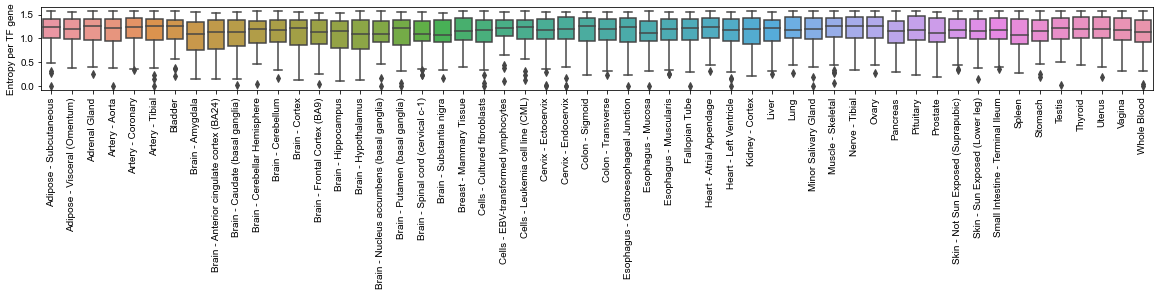

In [68]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16, 4)
sns.boxplot(data=entropy_per_tissue.loc[genes.value_counts() == 3, :],
            ax=ax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Entropy per TF gene')

In [69]:
genes.value_counts().value_counts().sort_index()

1     11
2     80
3     55
4     51
5     33
6     26
7     13
8     14
9     10
10     5
11     4
13     2
15     1
16     1
19     1
26     2
dtype: int64

In [70]:
entropy_per_tissue.idxmax().value_counts()

CREM    48
TCF4     6
dtype: int64

(SignificanceResult(statistic=0.8071661756678965, pvalue=2.9863164552039e-72),
 PearsonRResult(statistic=0.7636665768755918, pvalue=2.7236722045432524e-60))

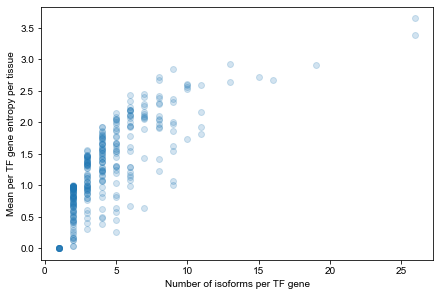

In [71]:
# looks like the entropy per tissue is mainly measuring the number of isoforms
fig, ax = plt.subplots(1, 1)
x = genes.value_counts()[entropy_per_tissue.index].values
y = entropy_per_tissue.mean(axis=1).values
ax.scatter(x, y, alpha=0.2)
ax.set_xlabel('Number of isoforms per TF gene')
ax.set_ylabel('Mean per TF gene entropy per tissue')
(stats.spearmanr(x, y), stats.pearsonr(x, y))

In [72]:
means.head()

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra,Breast - Mammary Tissue,Cells - Cultured fibroblasts,Cells - EBV-transformed lymphocytes,Cells - Leukemia cell line (CML),Cervix - Ectocervix,Cervix - Endocervix,Colon - Sigmoid,Colon - Transverse,Esophagus - Gastroesophageal Junction,Esophagus - Mucosa,Esophagus - Muscularis,Fallopian Tube,Heart - Atrial Appendage,Heart - Left Ventricle,Kidney - Cortex,Liver,Lung,Minor Salivary Gland,Muscle - Skeletal,Nerve - Tibial,Ovary,Pancreas,Pituitary,Prostate,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
UID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AEBP2-2 – novel isoform,0.962211,0.799885,1.016154,1.124623,0.851251,1.800171,2.074463,0.091542,0.215992,0.187908,0.333578,0.529055,0.249577,0.347101,0.086028,0.139775,0.150605,0.106099,0.100049,0.101037,1.044233,1.202637,1.612342,0.730029,0.931250,0.883679,0.655458,0.746159,0.554164,0.946936,0.627459,1.114986,0.574213,0.215004,0.329177,0.291285,0.766374,1.179799,0.623300,0.919944,1.074923,0.215611,5.317158e-01,0.604217,0.895972,1.258206,0.952588,0.255146,0.533307,0.803595,0.780167,7.737338e-01,0.936118,0.059826
AEBP2-3 – novel isoform,0.268170,0.196407,0.236194,0.434780,0.265301,0.559758,0.261886,0.075658,0.040791,0.075325,0.175803,0.098599,0.046694,0.068117,0.100050,0.040575,0.089277,0.088851,0.068390,0.130901,0.280883,0.170374,0.321807,0.123564,0.346574,0.389435,0.241720,0.171490,0.212160,0.134654,0.178033,0.437317,0.088535,0.091338,0.096742,0.067172,0.202085,0.298189,0.117821,0.303664,0.220533,0.091373,1.013912e-01,0.157172,0.418768,0.487326,0.144361,0.154604,0.126342,0.119019,0.221126,3.555410e-01,0.231763,0.022053
ARNT2-1 – ARNT2-201,1.322291,1.358729,1.333946,1.863271,1.938867,3.499845,2.364102,5.133839,5.707670,5.899168,4.621232,4.976012,6.025976,6.134232,5.435778,5.052950,5.853357,5.389557,4.718348,5.166459,1.169806,4.665058,0.089143,0.040871,1.894751,2.750963,2.527584,1.550656,2.257589,0.746795,2.295676,2.302673,1.316868,0.686960,3.007519,0.256917,1.991720,0.953176,2.079517,2.950450,3.085959,0.947473,3.592321e+00,2.332845,0.848058,1.081508,1.537082,1.740636,1.388945,2.877574,2.972234,2.174530e+00,1.550790,0.034479
ARNT2-2 – novel isoform,0.002652,0.013878,0.004267,0.004361,0.005085,0.028744,0.074687,0.074628,0.099122,0.122810,0.131279,0.117325,0.140344,0.211308,0.101764,0.053816,0.155837,0.091774,0.047191,0.058898,0.000000,0.157259,0.002488,0.002923,0.012428,0.016993,0.018597,0.009447,0.016538,0.000000,0.022605,0.000000,0.004576,0.011814,0.025930,0.020892,0.033116,0.003118,0.021252,0.008153,0.046976,0.003993,5.019670e-02,0.020434,0.006324,0.003766,0.002731,0.008321,0.012357,0.047552,0.034904,3.140963e-03,0.005553,0.002332
ARNT2-3 – ARNT2-209,0.000808,0.000466,0.003134,0.029415,0.005342,0.010932,0.000000,0.314553,0.269838,0.332912,0.220502,0.005362,0.016170,0.320560,0.886964,0.238343,0.513031,0.650514,0.005713,0.055405,0.007042,0.000000,0.013559,0.014268,0.000000,0.000000,0.003006,0.000485,0.005243,0.003211,0.000000,0.000000,0.010922,0.032817,0.014148,0.028037,0.013638,0.001471,0.009189,0.000000,0.002461,0.005243,4.542951e-07,0.000000,0.002078,0.004295,0.000000,0.000000,0.000000,0.000000,0.013552,1.127424e-08,0.009932,0.010185


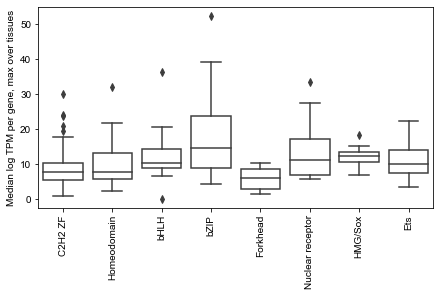

In [73]:
# median expression per gene, max across tissues, split by DBD
dbd_to_plot = list(tf_fam.value_counts()[tf_fam.value_counts() >= 20].index)
dbd_to_plot.remove('Unknown')

y_label = 'Median log TPM per gene, max over tissues'
data = (gene_medians.max(axis=1)
                    .to_frame(name=y_label)
                    .assign(family=gene_medians.index.map(tf_fam)))
data = data.loc[data['family'].isin(dbd_to_plot), :]
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=data,
            x='family',
            y=y_label,
            order=dbd_to_plot,
            ax=ax,
            boxprops={'facecolor': 'w'})
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90)
plt.savefig('../figures/GTEx_median-logTPM-per-gene-max-per-tissue_by-TF-family.pdf',
            bbox_inches='tight')

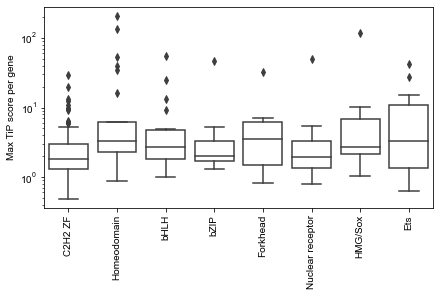

In [74]:
# tissue specific expression per gene, split by DBD
y_label = 'Max TiP score per gene'
data = (gene_tip.max(axis=1)[gene_medians.max(axis=1) >= 1]
                    .to_frame(name=y_label))
data['family'] = data.index.map(tf_fam)
data = data.loc[data['family'].isin(dbd_to_plot), :]
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=data,
            x='family',
            y=y_label,
            order=dbd_to_plot,
            ax=ax,
            boxprops={'facecolor': 'w'})
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90)
ax.set_yscale('log')
plt.savefig('../figures/GTEx_max-TiP-per-gene_by-TF-family.pdf',
            bbox_inches='tight')

In [75]:
# HACK BUGFIX 
# BUG: mapping genes.index to presentable names has broke downsteam code
df, metadata, genes = load_gtex_remapped()
means = df.groupby(df.columns.map(metadata['body_site']), axis=1).mean()

reading from cache


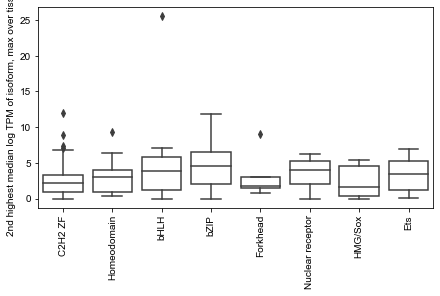

In [76]:
# expression of second highest isoform, split by DBD
y_label = '2nd highest median log TPM of isoform, max over tissues'
data = (medians.max(axis=1).groupby(genes).nth(1)
                    .to_frame(name=y_label))
data['family'] = data.index.map(tf_fam)
data = data.loc[data['family'].isin(dbd_to_plot), :]
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=data,
            x='family',
            y=y_label,
            order=dbd_to_plot,
            ax=ax,
            boxprops={'facecolor': 'w'})
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90)
plt.savefig('../figures/GTEx_median-logTPM-of-2nd-isoform_by-TF-family.pdf',
            bbox_inches='tight')

<ipython-input-77-a96aeefae9e0>:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)


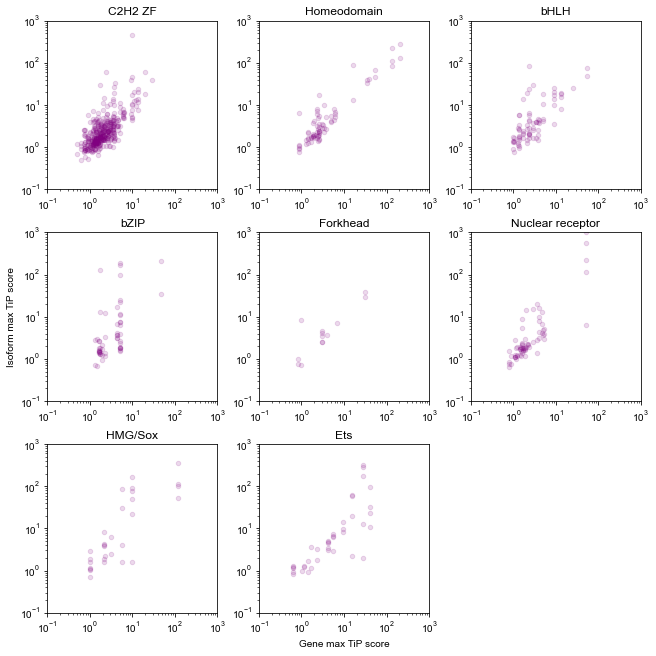

In [77]:
# scatter of gene vs isoform TiP by DBD
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(9, 9)
for dbd, ax in zip(dbd_to_plot, axs.flatten()):
    (iso.loc[(iso['max_logTPM'] > 1) & (iso['gene_symbol'].map(tf_fam) == dbd), :]
        .plot.scatter(x='gene_max_TiP_score',
                    y='max_TiP_score',
                    alpha=0.15,
                    color='purple',
                    ax=ax))
    ax.set_title(dbd)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim(0.1, 1000)
    ax.set_ylim(0.1, 1000)
axs[1, 0].set_ylabel('Isoform max TiP score')
axs[-1, 1].set_xlabel('Gene max TiP score')
axs.flatten()[-1].axis('off')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig('../figures/GTEx_isoform-vs-gene-TiP-score-scatter_by-TF-family.pdf',
                bbox_inches='tight')

In [78]:
iso.loc[(iso['max_logTPM'] > 1) & (iso['gene_symbol'].map(tf_fam) == 'bZIP')
        & ((iso['max_TiP_score'] / iso['gene_max_TiP_score']) > 5), :].sort_values('max_TiP_score', ascending=False)

,gene_symbol,mean_logTPM,median_logTPM,max_logTPM,max_TiP_score,tissue_with_max_TiP_score,entropy,gene_max_TiP_score,gene_entropy,TiP_diff,entropy_diff
UID,,,,,,,,,,,
noclone CREM-214,CREM,0.110146,0.000000,4.989521,190.747543,Testis,4.355871,5.214191,0.097398,185.533352,4.258473
noclone CREM-202,CREM,0.166607,0.000000,5.707661,173.175508,Testis,2.825728,5.214191,0.097398,167.961317,2.728330
noclone ATF2-221,ATF2,0.049805,0.000000,1.727089,125.719173,Testis,3.592857,1.780017,0.045165,123.939157,3.547691
noclone CREM-208,CREM,0.099448,0.000000,3.702145,95.929081,Testis,3.242656,5.214191,0.097398,90.714890,3.145258
ATF2|4/6|09B05 nomatch,ATF2,0.110833,0.000000,1.583342,13.220660,Testis,1.229797,1.780017,0.045165,11.440643,1.184632
CREB5|2/3|08A12 CREB5-202,CREB5,0.221702,0.087492,1.782179,12.212358,Whole Blood,0.638725,2.269297,0.122867,9.943061,0.515857


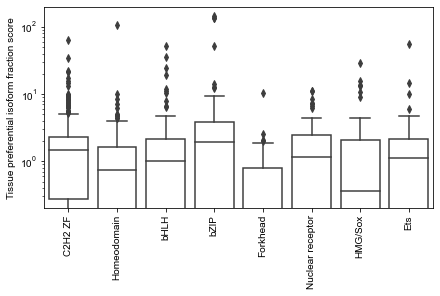

In [80]:
# ITiP (use the fraction of isoform to calculate TiP)
raw_means = 2 ** means - 1
fracs = raw_means / raw_means.groupby(genes).transform('sum')
itip = (fracs.sub(fracs.median(axis=1), axis=0)
                    .div(fracs.quantile(q=0.75, axis=1) -
                         fracs.quantile(q=0.25, axis=1), axis=0))

y_label = 'Tissue preferential isoform fraction score'
data = ((itip * (raw_means >= 1)).max(axis=1)
                    .to_frame(name=y_label)
                    .dropna())
data['family'] = data.index.map(genes).map(tf_fam)
data = data.loc[data['family'].isin(dbd_to_plot), :]
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=data,
            x='family',
            y=y_label,
            order=dbd_to_plot,
            ax=ax,
            boxprops={'facecolor': 'w'})
ax.set_xlabel('')
ax.xaxis.set_tick_params(rotation=90)
ax.set_yscale('log')
plt.savefig('../figures/GTEx_isoform-TiP_by-TF-family.pdf',
            bbox_inches='tight')

In [81]:
data.loc[data['family'] == 'bHLH', :].sort_values(y_label, ascending=False).head()

,Tissue preferential isoform fraction score,family
UID,,
noclone TCF4-203,51.693369,bHLH
HIF1A|2/4|08C04 HIF1A-212,35.109845,bHLH
noclone TCF4-246,24.134232,bHLH
noclone ARNT2-204_ARNT2-207,18.976677,bHLH
noclone MAX-211,11.741395,bHLH


<ipython-input-82-f6ac216b8dc8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
<ipython-input-82-f6ac216b8dc8>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


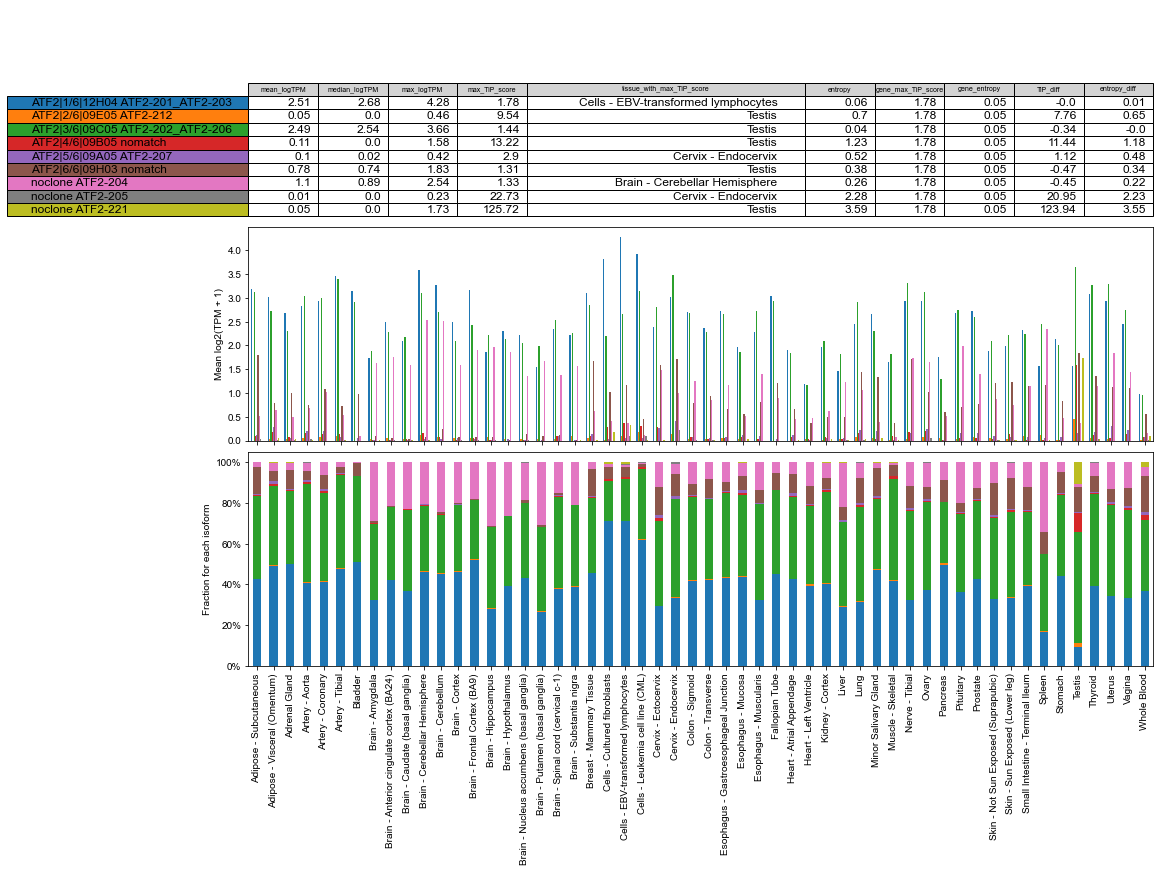

In [82]:
def table_and_graphs(gene_name):
    fig, axes = plt.subplots(3, 1, sharex=True)
    fig.set_size_inches(16, 12)
    ### table ###
    ncol = iso.shape[1] - 1
    data = iso.loc[iso['gene_symbol'] == gene_name, 
                   filter(lambda x: x != 'gene_symbol', iso.columns)].copy()
    data.index = data.index.str.replace('GC grp: ', '').str.replace('|' + gene_name+ '-', '/', regex=False)
    tab = pd.plotting.table(ax=axes[0],
                            data=data.round(2),
                            loc='lower center',
                            rowColours=['C' + str(i) for i in range((iso['gene_symbol'] == gene_name).sum())],
                            colColours=['lightgrey'] * ncol,
                            fontsize=32,
                            colWidths=[4 / (ncol + 3) if i == 4 else 1 / (ncol + 3) for i in range(ncol)])
    tab.auto_set_font_size(False)
    tab.set_fontsize(12)
    axes[0].axis('off')
    for key, cell in tab.get_celld().items():
        if key[0] == 0:
            cell.set_fontsize(7)
    ### bar chart ###
    (means.loc[genes == gene_name, :]
          .T
          .plot.bar(ax=axes[1],
                    legend=False,
                    width=0.7))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[2], 
                          stacked=True,
                          legend=False))
    axes[1].set_ylabel('Mean log2(TPM + 1)')
    #axes[0].set_title(gene_name)
    axes[2].set_ylabel('Fraction for each isoform')
    axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
    plt.subplots_adjust(hspace=0.05)
    fig_dir = Path('../figures/tissue_expression_per_gene')
    fig_dir.mkdir(exist_ok=True)
    plt.savefig(fig_dir / (gene_name + '_tissue_expression.pdf'),
                bbox_inches='tight')

table_and_graphs('ATF2')

In [85]:
# TODO: move this somewhere else
for gene_name in tqdm.tqdm_notebook(genes.unique()):
    break  # TMP
    if pd.isnull(gene_name):
        continue
    table_and_graphs(gene_name)
    plt.clf()

<ipython-input-85-b3e6359e585c>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for gene_name in tqdm.tqdm_notebook(genes.unique()):


  0%|          | 0/309 [00:00<?, ?it/s]

<ipython-input-82-f6ac216b8dc8>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
<ipython-input-82-f6ac216b8dc8>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


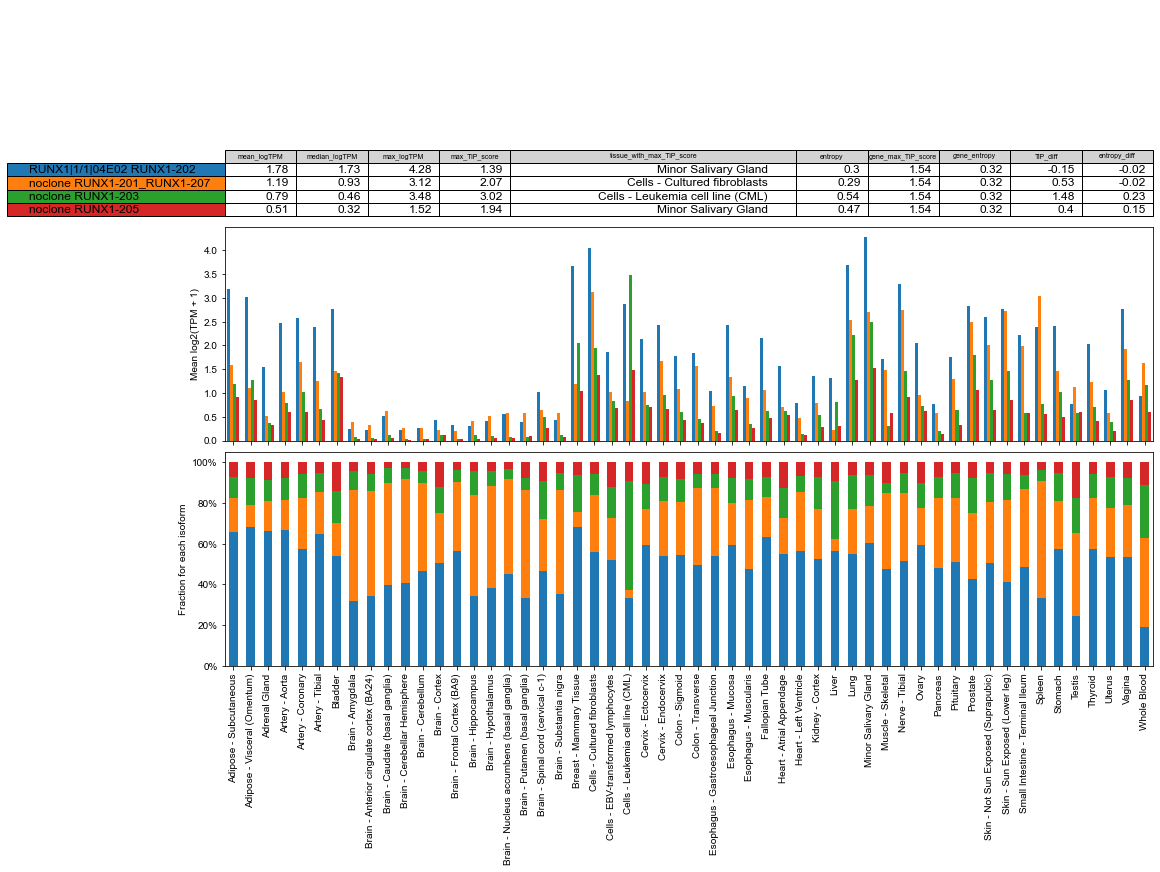

In [86]:
table_and_graphs('RUNX1')

<ipython-input-107-b54f6c3e85d0>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
<ipython-input-107-b54f6c3e85d0>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


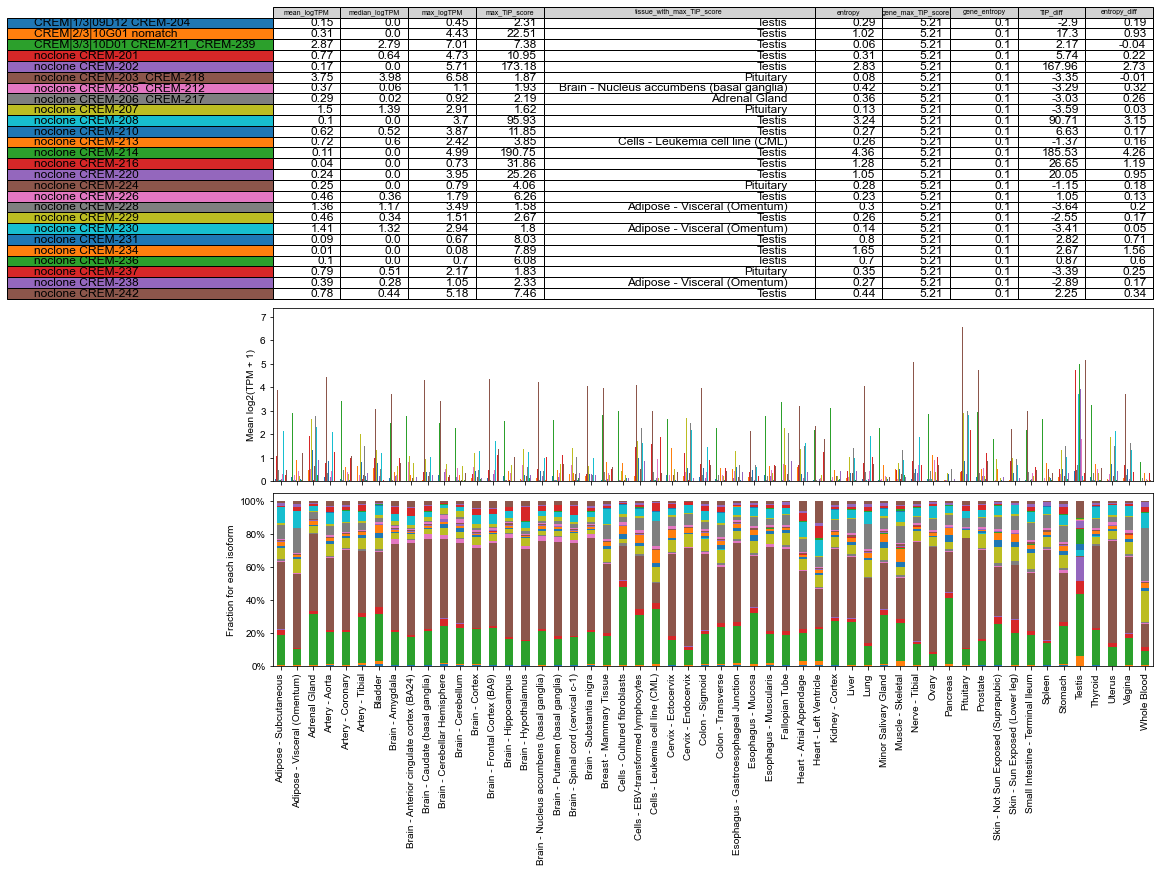

In [ ]:
# largest number of isoforms
table_and_graphs('CREM')

<ipython-input-107-b54f6c3e85d0>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
<ipython-input-107-b54f6c3e85d0>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


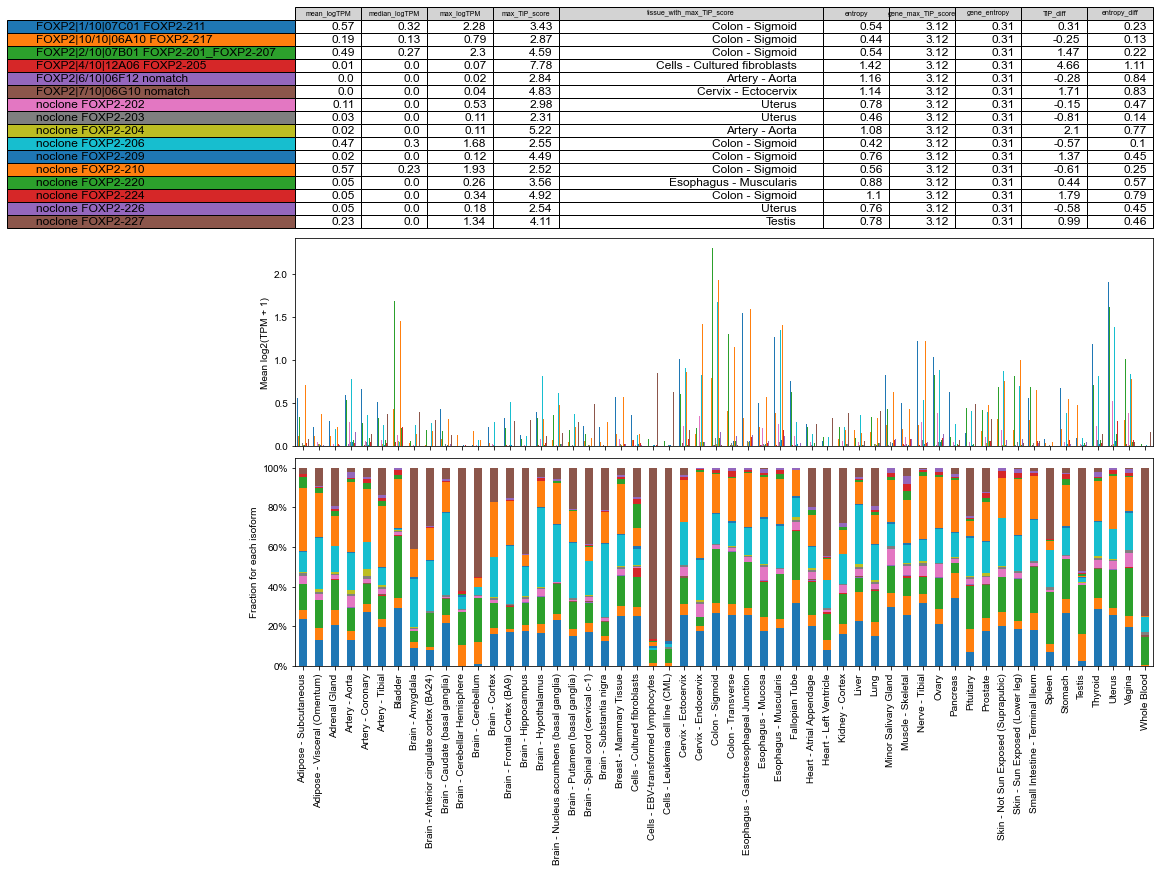

In [ ]:
table_and_graphs('FOXP2')

<ipython-input-107-b54f6c3e85d0>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
<ipython-input-107-b54f6c3e85d0>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


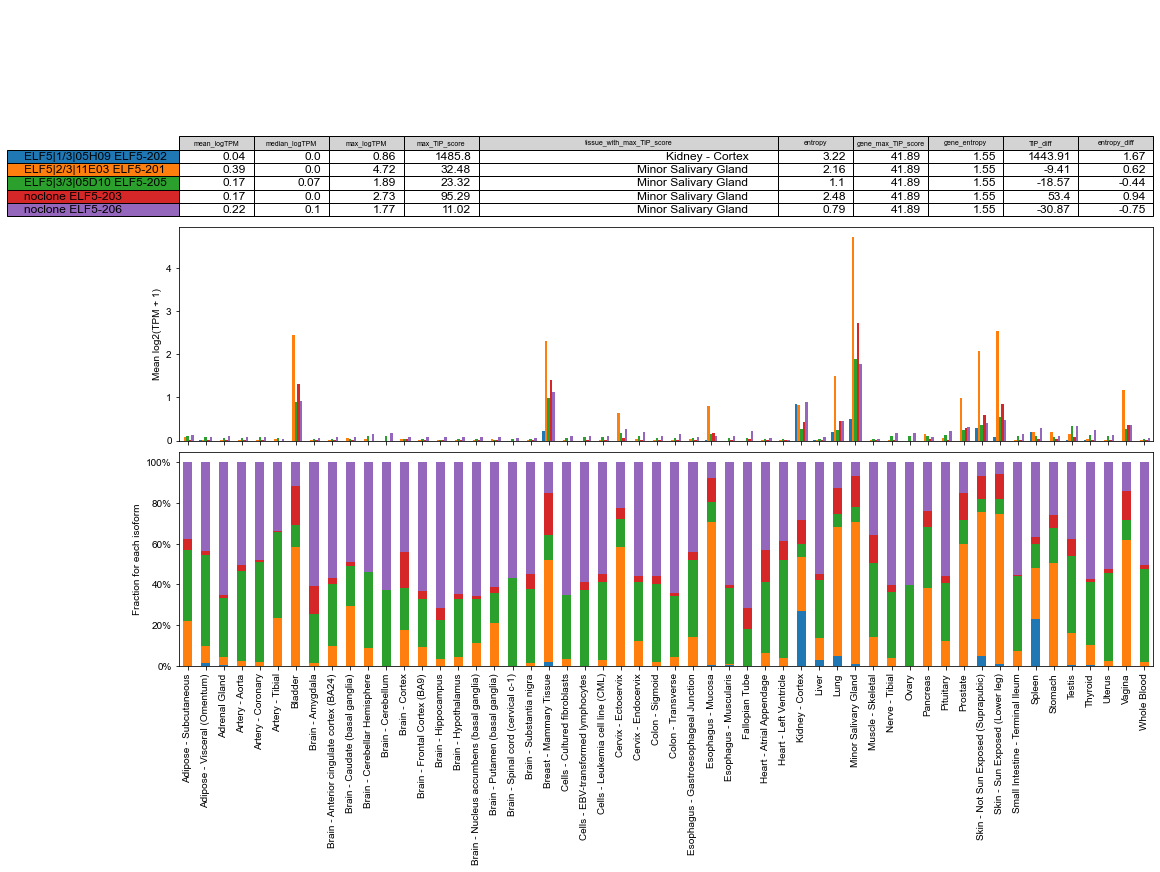

In [ ]:
table_and_graphs('ELF5')  # Zero counts

<ipython-input-107-b54f6c3e85d0>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
<ipython-input-107-b54f6c3e85d0>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


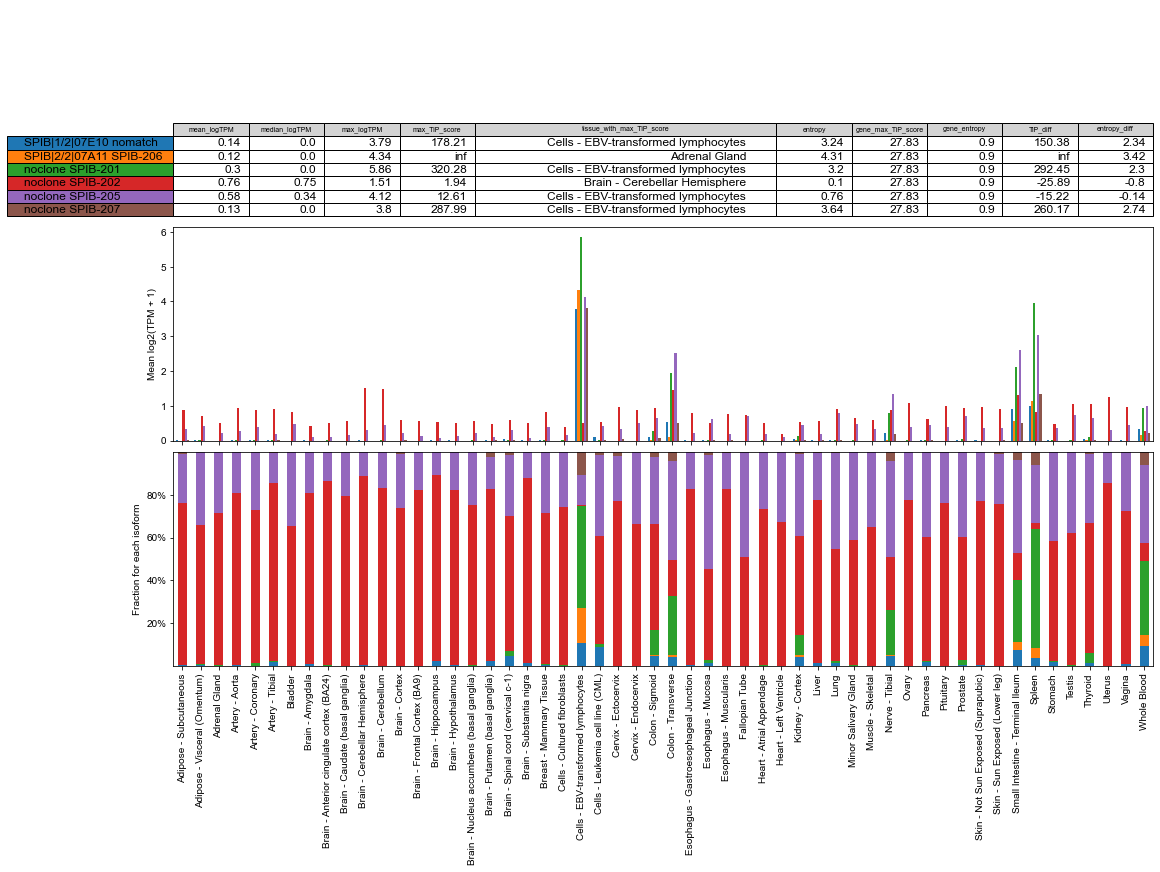

In [ ]:
table_and_graphs('SPIB')  # Zero counts

<ipython-input-107-b54f6c3e85d0>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
<ipython-input-107-b54f6c3e85d0>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


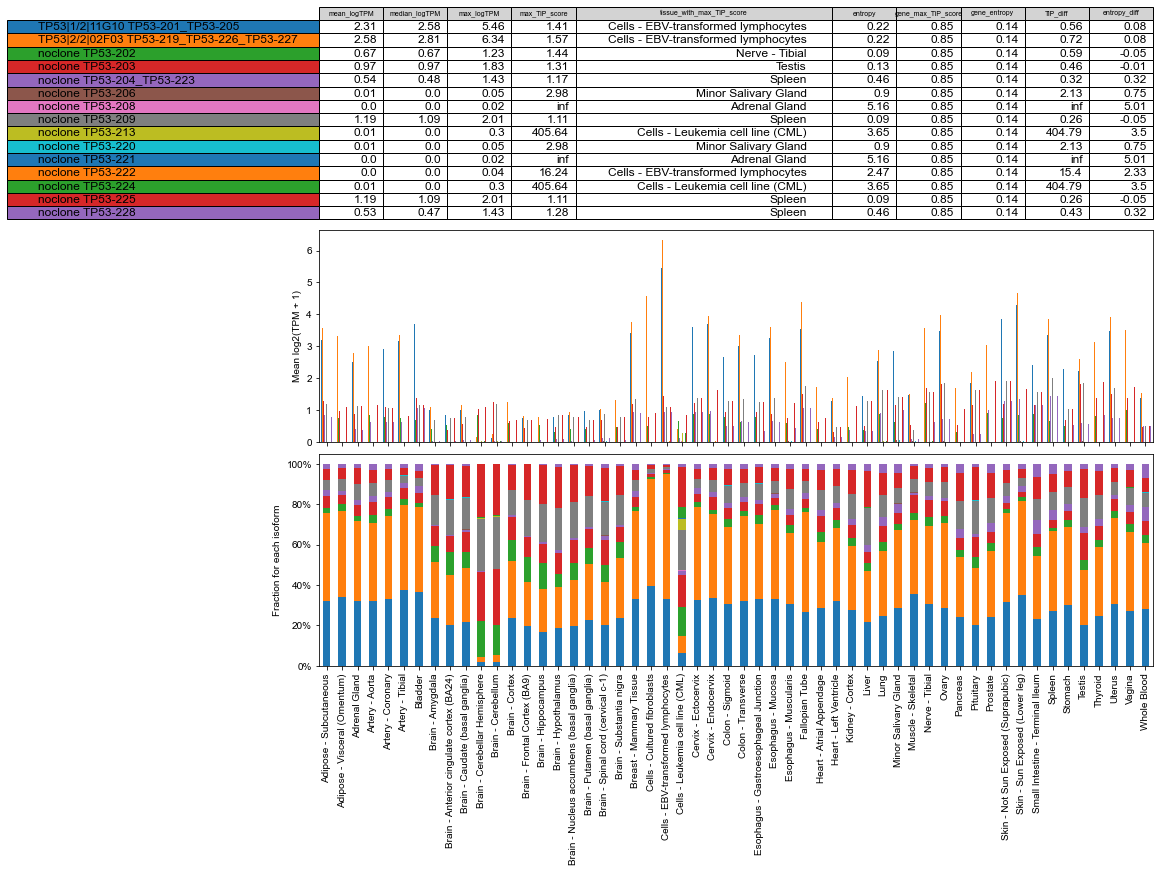

In [ ]:
table_and_graphs('TP53')

<ipython-input-107-b54f6c3e85d0>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_yticklabels(['{:.0%}'.format(t) for t in axes[2].get_yticks()])
<ipython-input-107-b54f6c3e85d0>:38: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.05)


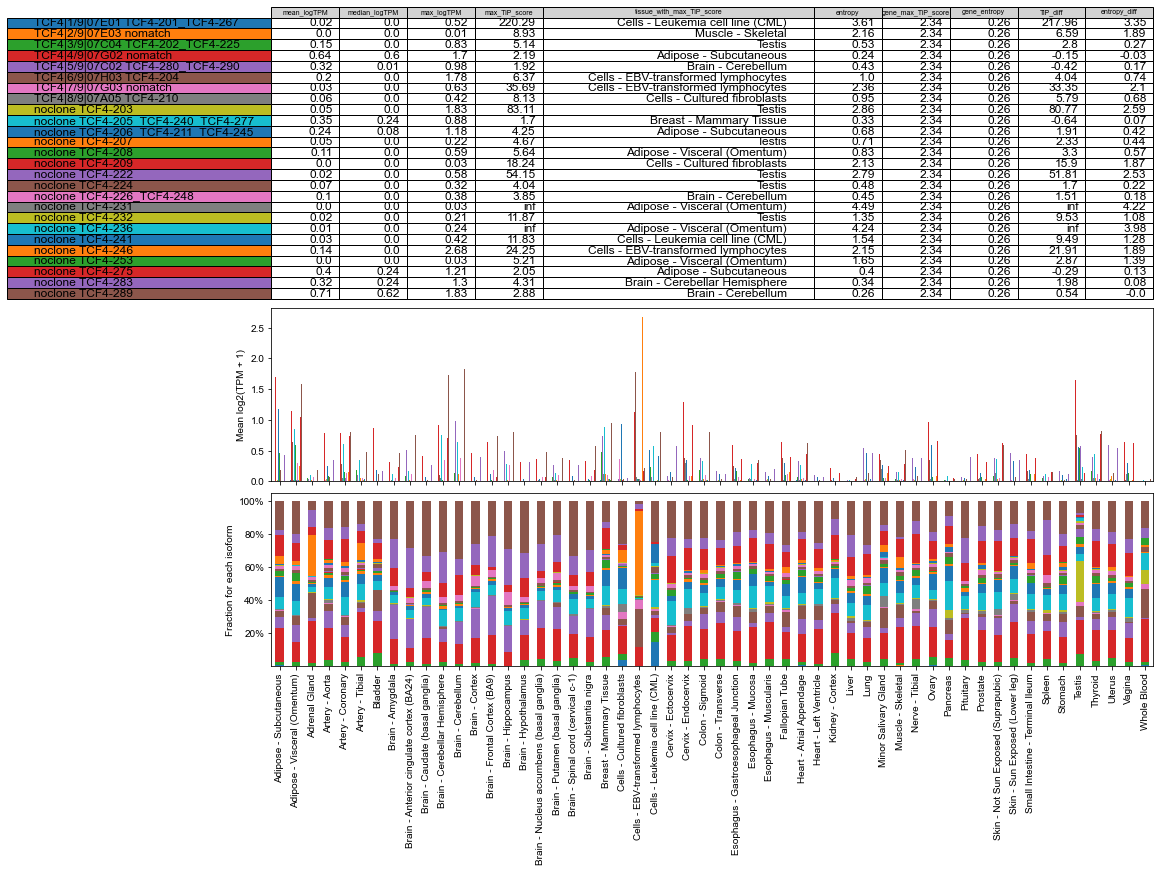

In [ ]:
table_and_graphs('TCF4')

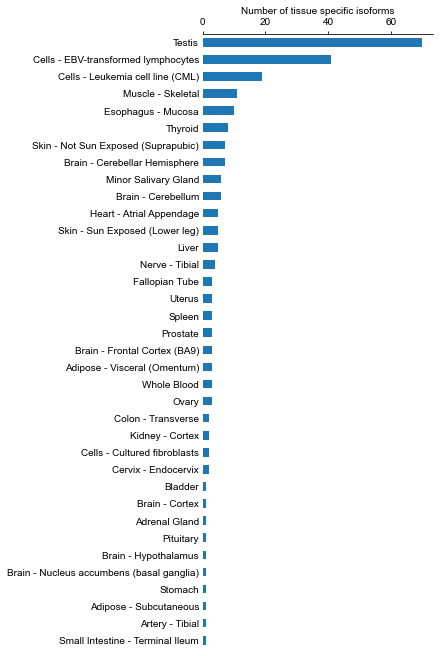

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 9)
iso.loc[(iso['max_logTPM'] > 1) & (iso['max_TiP_score'] > 5), 'tissue_with_max_TiP_score'].value_counts().plot.barh(ax=ax)
ax.invert_yaxis()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('Number of tissue specific isoforms')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
plt.savefig('../figures/number_tissue_specific_isoforms_per_tissue.pdf',
            bbox_inches='tight')

In [ ]:
df = pd.read_excel('../data/processed/gtex_analysis/ANOVA-GC30-basic-MainTissues_ratios-sparse.xlsx')

In [ ]:
df.shape

(3479, 4)

In [ ]:
(df['ANOVA-adjp'] < 0.05).sum()

3121

In [ ]:
df.head()

,Probesets,ANOVA-rawp,ANOVA-adjp,largest fold
0,GC grp: KCNIP3-201,0.0,0.0,0.911667
1,GC grp: ZSCAN29-202,0.0,0.0,0.607880
2,GC grp: ZNF207-204,0.0,0.0,0.657803
3,GC grp: ZNF207-201,0.0,0.0,0.518750
4,GC grp: CREM-202,0.0,0.0,0.165000


Text(0.5, 0, 'Largest fold')

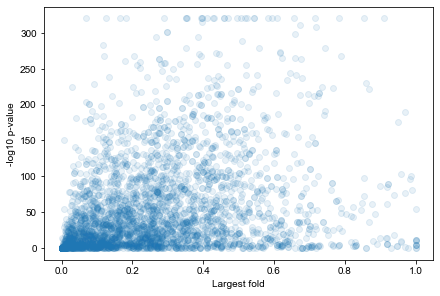

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['largest fold'].values,
           - np.log10(df['ANOVA-adjp'].values + np.float64('1E-320')),
           alpha=0.1)
ax.set_ylabel('-log10 p-value')
ax.set_xlabel('Largest fold')

In [ ]:
df = pd.read_excel('../data/processed/gtex_analysis/ANOVA-PSI.xlsx')

In [ ]:
df.head()

,uid,UID,ANOVA-rawp,ANOVA-adjp,dPSI
0,ZNF706,ZNF706:ENSG00000120963:E1.2-E6.1|ENSG000001209...,0.0,0.0,0.185663
1,KCNIP3,KCNIP3:ENSG00000115041:E6.1-E8.1|ENSG000001150...,0.0,0.0,0.978156
2,KCNIP3,KCNIP3:ENSG00000115041:E5.1-E8.1|ENSG000001150...,0.0,0.0,0.954040
3,CXXC5,CXXC5:ENSG00000171604:E8.4-E10.1|ENSG000001716...,0.0,0.0,0.293297
4,CXXC5,CXXC5:ENSG00000171604:E8.4-E9.2|ENSG0000017160...,0.0,0.0,0.328706


In [ ]:
(df['ANOVA-adjp'] < 0.05).sum()

9030

In [ ]:
df.shape

(10981, 5)

Text(0.5, 0, 'dPSI')

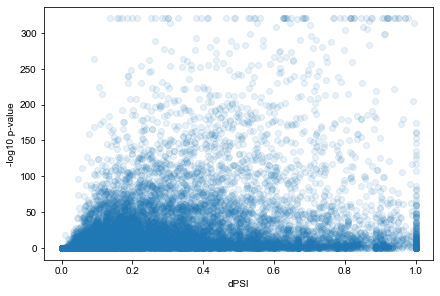

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['dPSI'].values,
           - np.log10(df['ANOVA-adjp'].values + np.float64('1E-320')),
           alpha=0.1)
ax.set_ylabel('-log10 p-value')
ax.set_xlabel('dPSI')